<a href="https://colab.research.google.com/github/shuvayan/BayesianMMM/blob/main/Causal_Data_Science_Bridging_Causal_thinking_and_Media_Mix_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.11.8


# Causal Data Science: Bridging Causal Thinking and Media Mix Modeling



## Introduction
In today’s fast-paced world of marketing analytics, grasping not just what works but also why it works is more crucial than ever. Traditional Media Mix Modeling (MMM) has been a staple for allocating budgets and assessing the effectiveness of various marketing channels based on the correlation between spending and outcomes. However, it's important to remember that correlation doesn’t equal causation. Relying solely on conventional MMM can lead to misleading or less-than-optimal conclusions.

This notebook seeks to bridge the gap between causal thinking and media mix modeling by incorporating causal inference techniques into MMM. By doing so, we can move beyond mere correlation insights to reveal the actual causal impact of marketing activities on business results. This approach strengthens marketing strategies, allowing for more effective budget allocation and an improved return on investment (ROI).

What You’ll Discover:

- The limitations of traditional Media Mix Modeling and why causal inference is vital in marketing analytics.
- Core concepts of causal data science, such as causal graphs and structural causal models.
- How to weave causal thinking into MMM to enhance the precision of marketing attribution.
- Practical implementation of causal MMM, complete with code examples and real-world data.

Why Emphasize Causal Thinking in MMM?

- Enhanced Decision Making: Understanding causal relationships helps marketers accurately predict the effects of changes in marketing spend.
- Refined Attribution: Causal MMM offers a more dependable way to attribute sales to marketing channels while considering confounding factors and interactions.
- Better Optimization: It enables the fine-tuning of marketing budgets by concentrating on activities that genuinely drive results.

Let’s embark on this journey to elevate our media mix models through the power of causal data science!

In [ ]:
#!pip install numpyro pymc-marketing dowhy

## Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pymc as pm
from pymc_marketing.mmm.transformers import geometric_adstock, michaelis_menten

import dowhy
from dowhy import CausalModel, gcm

from graphviz import Digraph
from IPython.display import display, SVG

In [ ]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({'figure.constrained_layout.use':True})

# We use a fixed random seed to ensure that our results are reproducible
seed = sum(map(ord, "Causal MMM"))
rng = np.random.default_rng(seed)

In [ ]:
# sampling options for PyMC
sample_kwargs = {"draws": 500, "chains": 4, "nuts_sampler": "numpyro"}

## Setting Up the Causal Graph

To explore the causal relationships within our media mix model, we’ll create a Directed Acyclic Graph (DAG). This graph visually represents our assumptions about how different marketing channels and external factors influence one another and ultimately affect our target outcome.

In this notebook, we’ll examine how to connect Directed Acyclic Graphs (DAGs), Structural Causal Models (SCMs), and the Data Generation Process (DGP) to deepen our understanding of causal relationships in marketing. We’ll start by visualizing a DAG that highlights the key elements influencing our target variable in the media mix model, followed by discussions on how each component translates into a causal representation of our marketing system.

## Directed Acyclic Graph (DAG) Overview

The DAG above illustrates a hypothetical scenario in which various factors impact the target variable, representing the desired outcome of a media campaign, such as sales or conversions.

Nodes and Their Interpretation:

1. **H (Holiday)**: This node represents seasonality in the form of holidays, which are often accompanied by specific consumer behaviors. The "holiday" node is depicted with dashed lines to signify that its influence is latent and often less directly observable, but still impactful.

2. **F (Facebook)**: This node represents advertising efforts on Facebook. Facebook can influence other channels, as well as contribute directly to our target outcome.

3. **G (Google Search)**: This node represents Google Search campaigns, which can be influenced by other marketing actions, such as Facebook advertising, and also impact the target variable.

4. **D (Discounts)**: This node refers to promotional discounts offered to consumers. Discounts often play a crucial role in consumer purchasing decisions.

5. **T (Target)**: This is the outcome node representing the target variable (such as sales or conversions) that we want to maximize.

### Edges and Their Relationships:

*Seasonality Effects (Holiday to Facebook and Google Search)*: The dashed arrows from "Holiday" (H) to both "Facebook" (F) and "Google Search" (G) indicate that these channels are influenced by seasonality. During holidays, both Facebook ad activity and Google search volume tend to increase, reflecting the broader seasonal impact on consumer behavior.

*Facebook Influences Google Search*: The edge from Facebook (F) to Google Search (G) represents a causal relationship where Facebook ads lead consumers to perform additional searches on Google, a common phenomenon known as "spillover effect."

### Direct Impact on Target:

*Facebook (F) to Target (T)*: Facebook ads contribute directly to the target outcome (T). This could be due to direct conversions resulting from Facebook campaigns.

*Google Search (G) to Target (T)*: Similarly, Google search ads have a direct effect on the target outcome, reflecting the role of search advertising in driving customer actions.

*Discounts (D) to Target (T)*: Promotional discounts directly influence the target variable. Discounts can significantly impact purchasing decisions, leading to increased conversions.

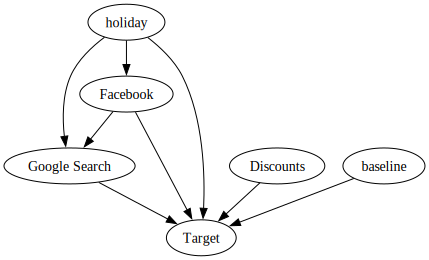

In [ ]:
# Initialize a directed graph
dot = Digraph()

# Add nodes
dot.node('H', 'holiday')
dot.node('F', 'Facebook')
dot.node('G', 'Google Search')
dot.node('D', 'Discounts')
dot.node('T', 'Target')
dot.node('B', 'baseline')

# Add edges to represent the relationships
dot.edge('H', 'G')  # Seasonality to Google
dot.edge('H', 'T')  # Seasonality to target
dot.edge('H', 'F')  # Seasonality to Facebook
dot.edge('F', 'G')  # Facebook influences Google Search
dot.edge('F', 'T')  # Facebook contributes Target
dot.edge('G', 'T')  # Google Search contributes to Target
dot.edge('D', 'T')  # Discounts contributes to Target
dot.edge('B', 'T')

# Render the graph to SVG and display it inline
svg_str = dot.pipe(format='svg')
display(SVG(svg_str))

$$
\begin{aligned}
\text{facebook} & = f_1(\text{holiday}) \\
\text{google}   &= f_2(\text{holiday}, \text{facebook}) \\
\text{target}   &= f_3(\text{baseline}, m(\text{google}), m(\text{facebook}), \text{discounts}, \text{holiday})
\end{aligned}
$$

where $m(\cdot)$ corresponds to adstock and saturation transformations that are commonly used in MMM's.

$$
\begin{align}
f_3 &= baseline \\
    & \quad + m(google) \\
    & \quad + m(facebook) \\
    & \quad + discounts \\
    & \quad + discounts \cdot [google + facebook ] \\
\end{align}
$$

## Why This DAG Matters?

Understanding this DAG is crucial for several reasons:

1. Causal Clarity: It helps us specify our assumptions about how variables causally influence each other, which is essential for accurate causal inference.
2. Identifying Confounders: Seasonality is a common cause of multiple variables in the model. Recognizing this helps us control for it appropriately to avoid biased estimates.
3. Model Specification: The DAG guides us in building our statistical models, ensuring we include the necessary variables and interactions to capture the true causal relationships.

## Generating simulated data

In [ ]:
time_periods = (365*2)  # Number of days for which we are simulating ad spend multiply by years

Discounts are a critical part of many marketing strategies, often used to drive customer acquisition or increase engagement. To capture the effect of discounts over time, we simulate daily discount values with random variation and occasional spikes, reflecting promotional events or seasonal sales.

In [ ]:
def generate_discounts():
  """Simulating daily discounts"""
  discounts = rng.beta(5, 8, size=time_periods)
  discounts[20:25] *= 0.9  # Adding a spike in discounts
  discounts[70:75] *= 0.7
  discounts[255:265] *= 0.4
  discounts[555:665] *= 0.2
  discounts[885:895] *= 0.3
  # smooth with average the signal by mean 10 days
  discounts = np.convolve(discounts, np.ones(10)/10, mode='same')
  # weighting
  discounts_coeff = 1.5
  discounts_effect = discounts * discounts_coeff
  return discounts, discounts_effect

To simulate the seasonality effects of holidays, we generate a latent variable that represents the holiday effect over time. Instead of limiting this effect to a single day, we apply a Gaussian basis function to create a smoothly varying influence around each holiday date. This approach captures both the gradual buildup to the holiday and its subsequent fade.

**Methodology**

1. **Holiday Dates**: We specify specific dates representing holidays across the year. In this example, a single holiday is set on day 300.
   
2. **Gaussian Basis for Smoothing**: For each holiday date, we create a Gaussian curve centered on the holiday date with a standard deviation of 30 days. This parameter defines the spread of the holiday effect, peaking on the holiday itself and gradually tapering off on either side.

3. **Yearly Wrapping**: To handle seasonality across the years, we also include the holiday effect around day 665 (300 + 365), simulating the same holiday in the following year for continuity in time series analysis.

4. **Combining Effects**: We sum the Gaussian curves for each holiday instance to obtain a continuous holiday effect throughout the year. The parameter `holiday_coef` scales this effect, resulting in a final holiday contribution that can be incorporated as a feature in further modeling steps.

In [ ]:
def generate_holiday():
  holiday_dates = [300]  # Single holiday occurring on day 300 each year
  holiday_effect = np.zeros(time_periods)

  # Parameters for the Gaussian basis
  std_dev = 30  # Controls the spread of the holiday effect around each holiday date

  time_range = np.arange(time_periods)
  holiday_signal = np.sum(
      [
          np.exp(-0.5 * ((time_range - holiday) / std_dev)**2)
          + np.exp(-0.5 * ((time_range - (holiday + 365)) / std_dev)**2)
          for holiday in holiday_dates
      ],
      axis=0,
  )

  holiday_coef = 3

  holiday_contribution = holiday_signal * holiday_coef
  return holiday_signal, holiday_contribution

We start by generating Facebook ad impressions with random noise and intentional spikes to mimic real-world advertising patterns. We use a uniform distribution to introduce variability in daily impressions. Specific intervals are selected to include spikes, representing marketing campaigns or promotional bursts that significantly increase ad impressions.

**Methodology**

1. **Base Ad Impressions**: We initialize the daily Facebook ad impressions using a uniform distribution with values between 2 and 6. This distribution reflects baseline variability in ad reach. To smooth the signal and make it more realistic, we apply a 14-day moving average using convolution. This step helps dampen daily fluctuations and simulate a more stable trend across periods.

2. **Spikes for Campaigns**: To represent distinct campaigns, we add spikes in impressions on specific day ranges (e.g., days 20-25, 70-75, etc.). Each spike represents heightened engagement due to particular promotional efforts.

3. **Holiday Effects**: The variable `holiday` is introduced with a coefficient of 0.5, simulating the additional impressions expected around holidays due to increased ad engagement. Gaussian noise (mean of 0 and standard deviation of 0.05) is added to maintain some natural variability.

4. **Non-Linear Transformation for Ad Effects**: We apply a non-linear transformation to the ad impressions using the **Michaelis-Menten** function, which is common in advertising spend models. Before this, we apply **Geometric Adstock** to capture diminishing returns over time. Here:
   - `alpha_fb` is the maximum contribution for Facebook, set to 25.
   - `lam` represents the common spend threshold, set to 20.

5. **Moderation by Daily Discounts**: To model the interaction effect between daily discounts and Facebook impressions, we introduce a moderation coefficient (`moderation_facebook_coeff`) of 0.03. This models how discounts might moderate the ad impressions' effect, resulting in an additional feature for analysis.

The final output includes the adjusted Facebook impressions and the combined effect after accounting for holiday influences, adstock/saturation transformation, and discount moderation.

In [ ]:
def generate_facebook(holiday, daily_discounts):
  """Simulating Facebook ad impressions with random noise and spikes"""
  facebook_impressions = rng.uniform(low=2, high=6, size=time_periods)
  facebook_impressions[20:25] += 10  # Adding a spike in ad impressions
  facebook_impressions[70:75] += 7
  facebook_impressions[255:265] += 4
  facebook_impressions[344:455] += 2
  facebook_impressions[885:895] += 3
  # Average the signal by mean 14 days
  facebook_impressions = np.convolve(facebook_impressions, np.ones(14)/14, mode='same')

  facebook_holiday_coeff = 0.5

  facebook_impressions = facebook_impressions + holiday * facebook_holiday_coeff + np.random.normal(0, 0.05, time_periods)

  # Apply non-linear marketing transformations
  alpha_fb = 25  # Maximum contribution for Facebook
  lam = 20  # Common spend threshold for both
  facebook_effect = michaelis_menten(
      geometric_adstock(facebook_impressions, alpha=.4, l_max=28),
      alpha_fb, lam
  ).eval()

  moderation_facebook_coeff = .03
  moderation_effect_discounts_facebook = (
      daily_discounts * (facebook_impressions * moderation_facebook_coeff)
  )

  return facebook_impressions, (facebook_effect + moderation_facebook_coeff)

Following the Facebook ad simulation, we simulate Google Search Brand ad impressions, incorporating random noise, intentional spikes, and lagged influence from Facebook. This setup aims to model realistic advertising patterns for Google, capturing both independent trends and cross-platform influences.

**Methodology**

1. **Base Ad Impressions**: We initialize the daily Google ad impressions using a uniform distribution with values between 3 and 7, reflecting a baseline range for Google reach. We apply a 14-day moving average using convolution to smooth the daily impressions. This step stabilizes the trend by reducing random fluctuations and providing a more realistic representation of ad reach over time.

2. **Spikes for Campaigns**: Similar to Facebook, we add spikes in impressions at specific intervals (e.g., days 45-50, 95-105, etc.) to represent distinct campaigns or events that significantly increase impressions. Notably, some spikes are time-lagged compared to Facebook, capturing a potential delay in Google’s response to parallel marketing efforts.

3. **Cross-Platform Influence from Facebook**: To account for cross-platform effects, we introduce a coefficient (`facebook_to_google_coeff` = 0.5) that scales Facebook impressions to reflect a lagged influence on Google impressions. This models the idea that high engagement on Facebook might drive additional Google searches.

4. **Holiday Effects**: We also introduce holiday effects with a higher coefficient for Google (`google_holiday_coeff` = 1.3), simulating increased engagement around holidays. A small Gaussian noise term (mean 0, standard deviation 0.1) is added to further simulate natural variability.

5. **Non-Linear Transformation for Ad Effects**: As with Facebook, we apply the **Michaelis-Menten** transformation to the adjusted Google impressions, which captures saturation effects in advertising. The **Geometric Adstock** function is used first to account for diminishing returns over time. Here:
   - `alpha_google` is the maximum contribution for Google, set to 20.
   - `lam` represents the common spend threshold for saturation, set to 20.

6. **Moderation by Daily Discounts**: We introduce a moderation effect with a coefficient of 0.02 for Google, modeling the interaction between daily discounts and Google impressions. This effect adjusts impressions further based on discount activity, producing an additional feature for analysis.

The final output includes the adjusted Google impressions and the combined effect after accounting for holiday influences, cross-platform effects from Facebook, adstock/saturation transformation, and discount moderation.

In [ ]:
def generate_google(facebook, holiday, daily_discounts):
  """Simulating Google Search Brand ad impressions with random noise and spikes, and some lagged influence from Facebook"""
  google_impressions = rng.uniform(low=3, high=7, size=time_periods)
  google_impressions[45:50] += 10  # Adding a spike, slightly delayed compared to Facebook
  google_impressions[95:105] += 6
  google_impressions[205:225] += 3
  google_impressions[404:499] += .5
  google_impressions[800:885] += 2
  # Average the signal by mean 14 days
  google_impressions = np.convolve(google_impressions, np.ones(14)/14, mode='same')

  facebook_to_google_coeff = .5  # Influenced by facebook
  google_holiday_coeff = 1.3  # Influenced by seasonality
  # Simulating the seasonality-adjusted effects for Facebook and Google
  google_impressions = (
      google_impressions
      + (facebook * facebook_to_google_coeff)
      + (holiday * google_holiday_coeff)
      + np.random.normal(0, 0.1, time_periods)
  )

  # Apply non-linear marketing transformations
  lam = 20  # Common spend threshold for both
  alpha_google = 20  # Maximum contribution for Google
  google_effect = michaelis_menten(
      geometric_adstock(google_impressions, alpha=.6, l_max=28),
      alpha_google, lam
  ).eval()

  moderation_google_coeff = .02
  moderation_effect_discounts_google = (
      daily_discounts * (google_impressions * moderation_google_coeff)
  )
  return google_impressions, (google_effect + moderation_google_coeff)

Finally, we define the target variable (sales). We assume it is a linear combination of the effects signal, the holiday and the discount components. We also add some noise to represent effects of unobserved influences.

In [ ]:
def generate_target(holiday, discounts, facebook, google,):
  base = 3
  noise = rng.normal(0.05, 0.15, time_periods)  # Adding some noise to the target variable

  # Simulating the target variable
  target = (
      base +
      holiday +
      facebook +
      google +
      discounts +
      noise
  )
  return target

Now our data generation process follows the same structure as our DAG, from the parent to the child nodes.

In [ ]:
daily_discounts, daily_discounts_contribution = generate_discounts()
holiday, holiday_contribution = generate_holiday()
facebook_impressions, facebook_contribution = generate_facebook(holiday_contribution, daily_discounts)
google_impressions, google_contribution = generate_google(facebook_impressions, holiday_contribution, daily_discounts)
target = generate_target(
    holiday_contribution,
    daily_discounts_contribution,
    facebook_contribution,
    google_contribution
)

## The real challenge starts

In real-world scenarios, we rarely have complete knowledge of the data generation process (DGP) or the structure of the underlying causal graph (DAG) for our dataset. Instead, we often begin with a raw dataset that represents observed variables, without any inherent structure or known relationships between them.

In [ ]:
df = pd.DataFrame({
    "time": np.arange(time_periods),
    "facebook": facebook_impressions,
    "google": google_impressions,
    "discounts": daily_discounts,
    "net_sales_amount": target
})

df.head()

time  facebook    google  discounts  net_sales_amount
0     0  1.966590  3.556847   0.219913          8.413863
1     1  2.332860  4.068742   0.262188         11.396634
2     2  2.586871  4.454154   0.290875         13.382481
3     3  2.978207  4.968452   0.314566         14.746738
4     4  3.131842  5.353973   0.364287         15.835302

## Visualizing our variables

We start by conducting a thorough exploratory analysis of the data. This typically includes summary statistics, visual inspections, and descriptive plots. We may plot distributions of each variable individually, examine time trends, or compare groups if relevant. EDA helps us identify outliers, missing values, and preliminary patterns that guide further investigation.

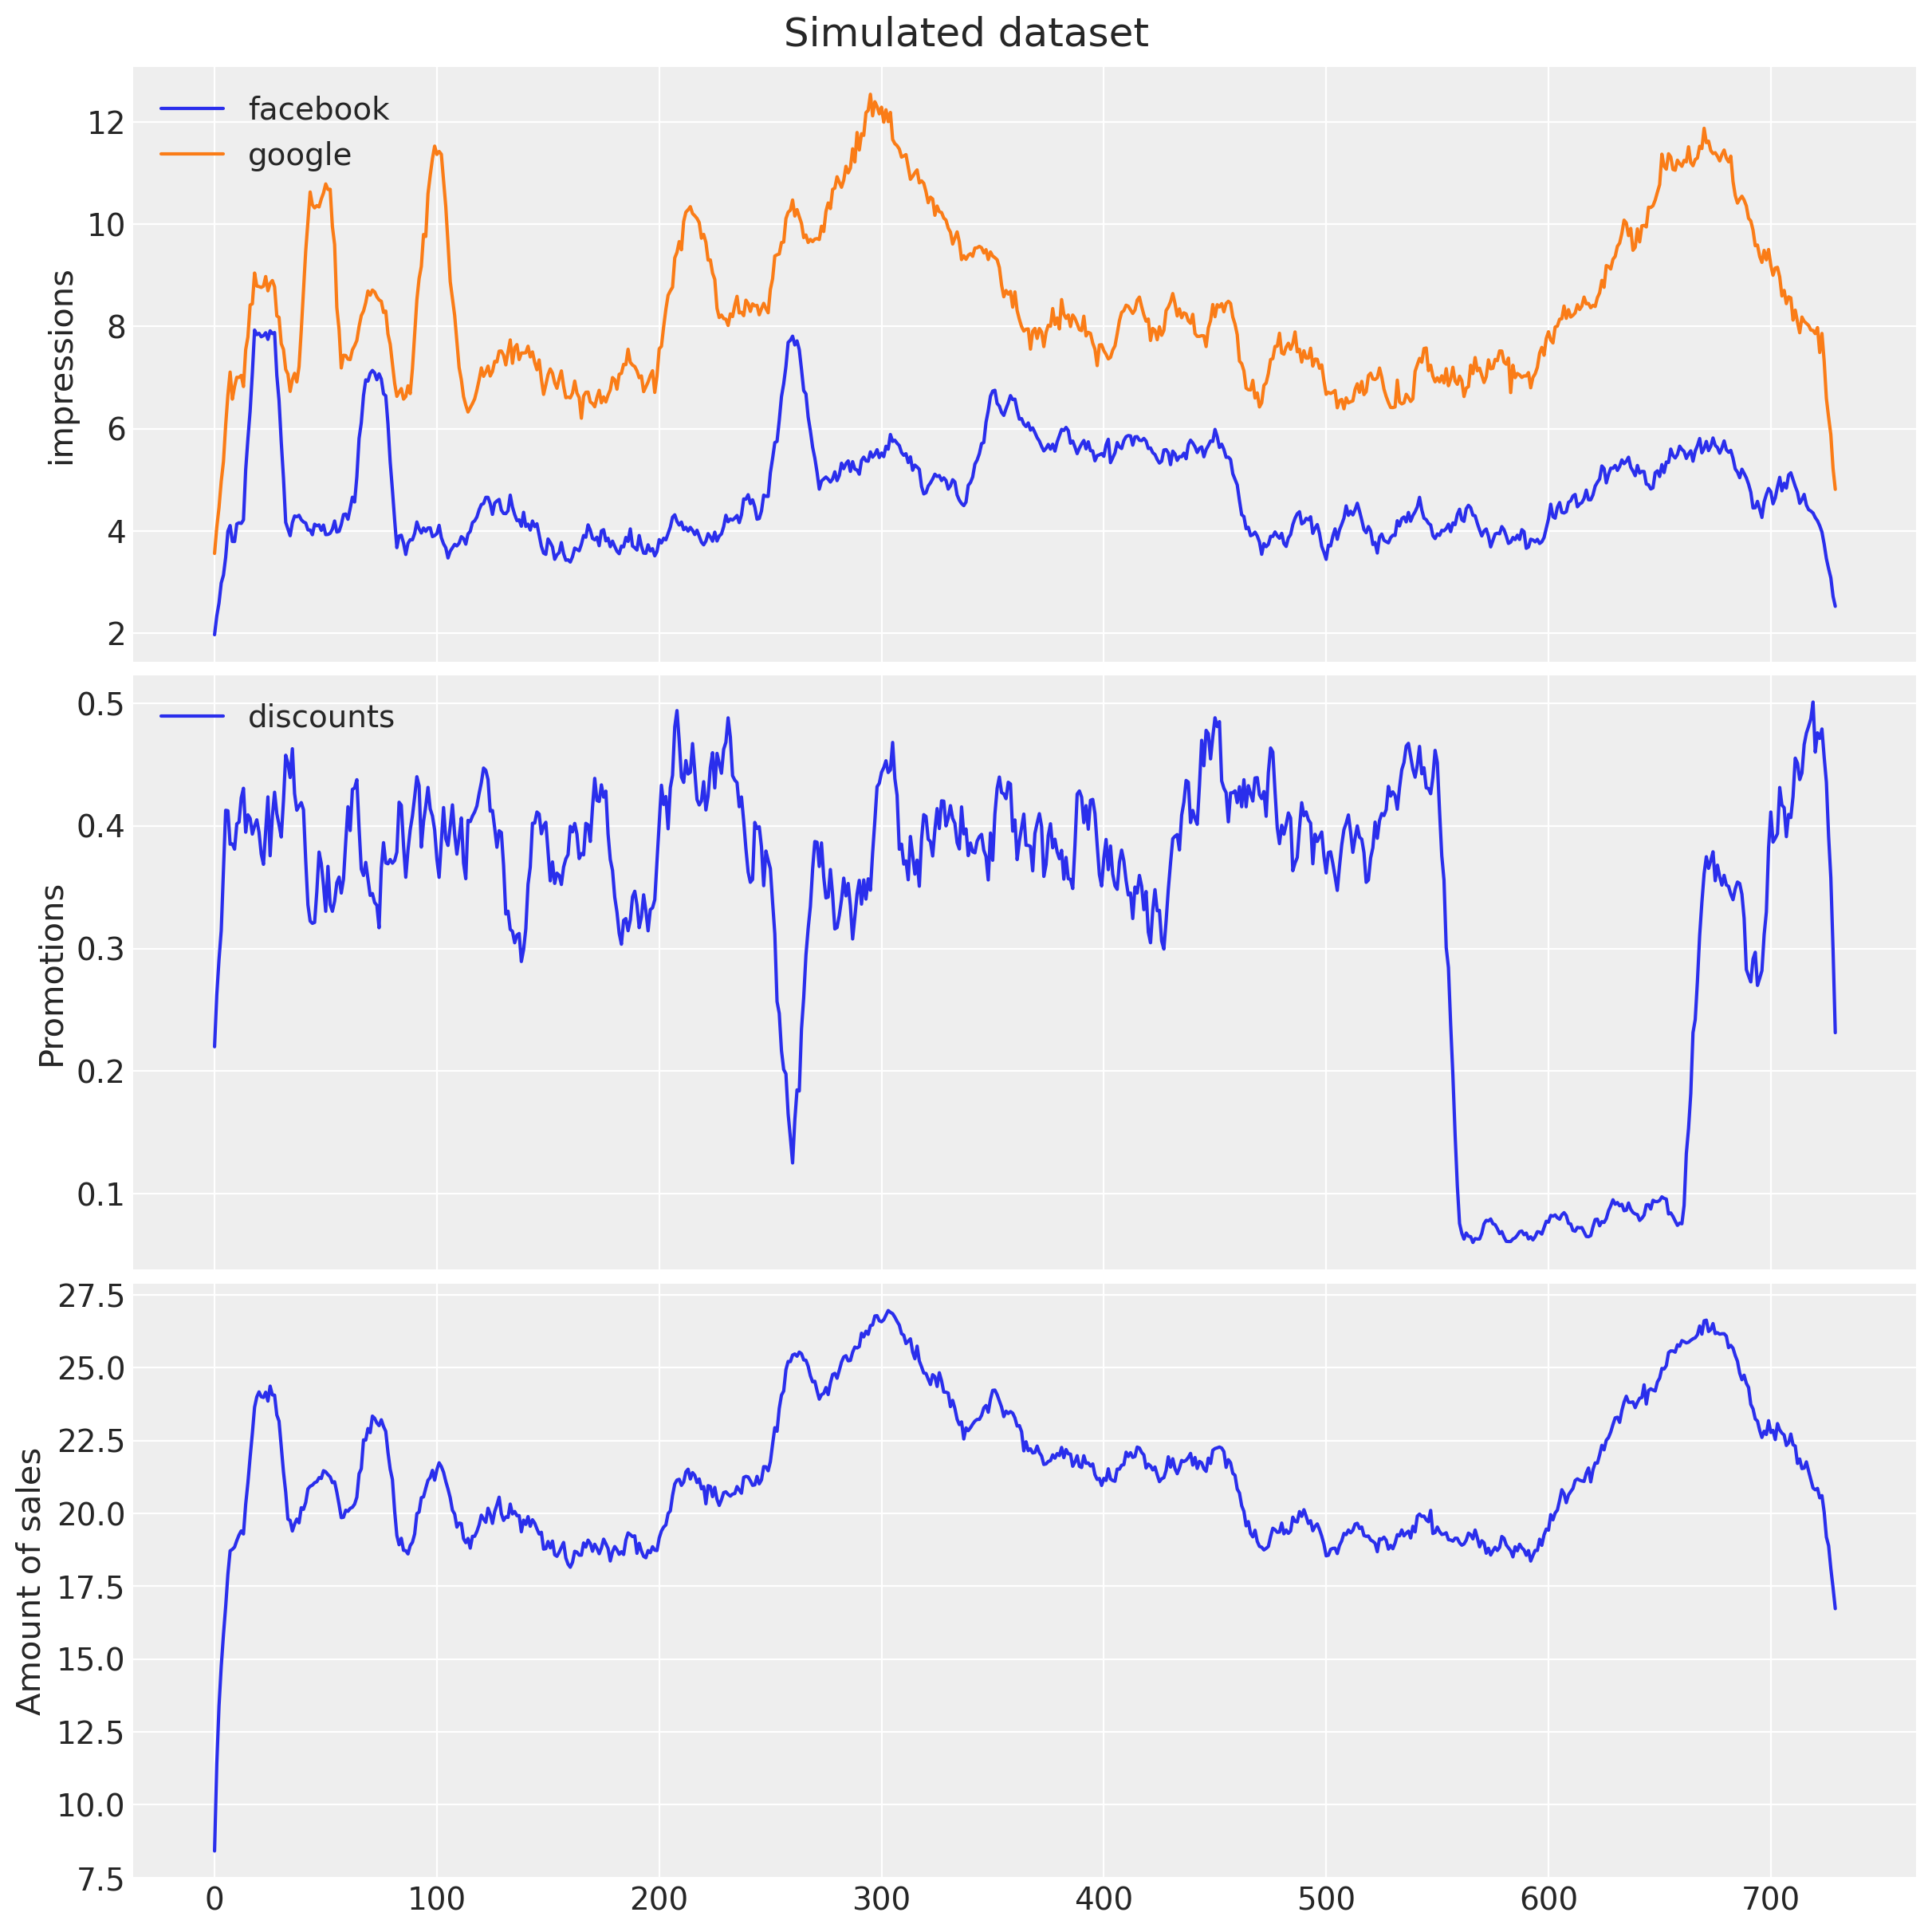

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

df[["facebook", "google"]].plot(ax=ax[0])
ax[0].set(ylabel="impressions")

df[["discounts"]].plot(ax=ax[1])
ax[1].set(ylabel="Promotions")

df[["net_sales_amount"]].plot(ax=ax[2], legend=False)
ax[2].set(ylabel="Amount of sales")

plt.suptitle("Simulated dataset", fontsize=18);

Additionally, correlation analysis provides a quantitative measure of linear relationships between variables. By plotting and calculating correlation matrices, we can spot potential dependencies and high correlations, which may suggest direct or indirect associations. However, correlation alone does not imply causation, so these findings serve as initial clues rather than definitive conclusions.

In [ ]:
df.corr()

time  facebook    google  discounts  net_sales_amount
time              1.000000  0.015945  0.098283  -0.420517          0.183983
facebook          0.015945  1.000000  0.481401  -0.012914          0.740668
google            0.098283  0.481401  1.000000  -0.092277          0.895043
discounts        -0.420517 -0.012914 -0.092277   1.000000         -0.045728
net_sales_amount  0.183983  0.740668  0.895043  -0.045728          1.000000

## Model 1: Basic Media Mix Model

Once we get a good grasp of all the variables, we can start thinking about how to represent our problem mathematically. With the data we have, we can create a regression model that highlights the main factors influencing our outcome variable. This is what makes up our **Marketing Mix Model (MMM)**, where each component reflects a unique element of the data we've observed, and how it contribute.

The regression equation for our MMM can be expressed as follows:

$$
\begin{aligned}
\mu & = \beta_0 \cdot \text{baseline} + \beta_1 \cdot \text{discounts} +
   m(\text{facebook}, \theta_{\text{facebook}}) +
   m(\text{google}, \theta_{\text{google}})
\end{aligned}
$$

Here:
- $\mu$ represents the predicted outcome variable (e.g., sales, revenue) based on the combined effects of our input variables.
- \( $\beta_0$ \) and \( $\beta_1$ \) are coefficients for the baseline and discount variables, respectively.
- \( $m(\text{facebook}$, $\theta_{\text{facebook}}$) \) and \( $m(\text{google}$, $\theta_{\text{google}}$) \) are non-linear transformations of Facebook and Google ad impressions, governed by parameters \( $\theta_{\text{facebook}}$ \) and \( $\theta_{\text{google}}$ \), capturing their potentially diminishing or saturating returns on the outcome.

As is pretty much standard in the industry, we can create a Bayesian model to represent this equation, in the same way that [Google Meridian](https://developers.google.com/meridian) or other softwares like [PyMC-Marketing](https://www.pymc-marketing.io/en/stable/index.html) does.

For now, we'll stick to the [PyMC](https://www.pymc.io/welcome.html) language to create and fit our first model.

In [ ]:
def build_model1():
  coords = {
      "time": df.time.unique(),
      "channel": ["facebook", "google"],
      "discounts": ["discounts"],
  }

  # Step 1: Define the PyMC Model with Transformed Variables
  with pm.Model(coords=coords) as model:
      # Load Data
      impressions = pm.Data("impressions", value=df[["facebook", "google"]].values, dims=("time", "channel"))
      discounts = pm.Data("_discounts", value=df[["discounts"]].values, dims=("time", "discounts"))
      target = pm.Data("target", value=df["net_sales_amount"].values, dims="time")

      # Priors for unknown model parameters
      base = pm.Gamma("base", mu=4, sigma=3)
      alpha_saturation = pm.Gamma("alpha_saturation", mu=20, sigma=30, dims="channel")
      alpha_adstock = pm.Beta("alpha_adstock", alpha=20, beta=30, dims="channel")
      lam = pm.Gamma("lam", mu=10, sigma=20)
      sigma = pm.Gamma("sigma", beta=4, alpha=3)

      # Transforming the Facebook and Google variables
      impressions_contribution = pm.Deterministic(
          'impressions_transformed',
          michaelis_menten(
              geometric_adstock(impressions, alpha=alpha_adstock, l_max=28),
              alpha=alpha_saturation,
              lam=lam
          ),
          dims=("time","channel")
      )

      # Weighting of discounts data
      discounts_beta = pm.Gamma("discounts_beta", mu=1, sigma=1)
      discounts_contribution = pm.Deterministic(
          "discounts_contribution",
          discounts_beta * discounts,
          dims=("time", "discounts")
      )

      # Expected value of target variable
      mu = (
          base +
          impressions_contribution.sum(axis=-1) +
          discounts_contribution.sum(axis=-1)
      )

      pm.Normal('likelihood', mu=mu, sigma=sigma, observed=target, dims="time")
      return model

In [ ]:
model1 = build_model1()

with model1:
    idata1 = pm.sample_prior_predictive(random_seed=rng)
    idata1.extend(pm.sample(random_seed=rng, **sample_kwargs))
    idata1.extend(pm.sample_posterior_predictive(idata1, random_seed=rng))

Sampling: [alpha_adstock, alpha_saturation, base, discounts_beta, lam, likelihood, sigma]


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

### Evaluation
Like any other model, we can evaluate the results of our training to see how it has behaved. We can usually verify the model's fit by evaluating its $R^2$ or $MAPE$.

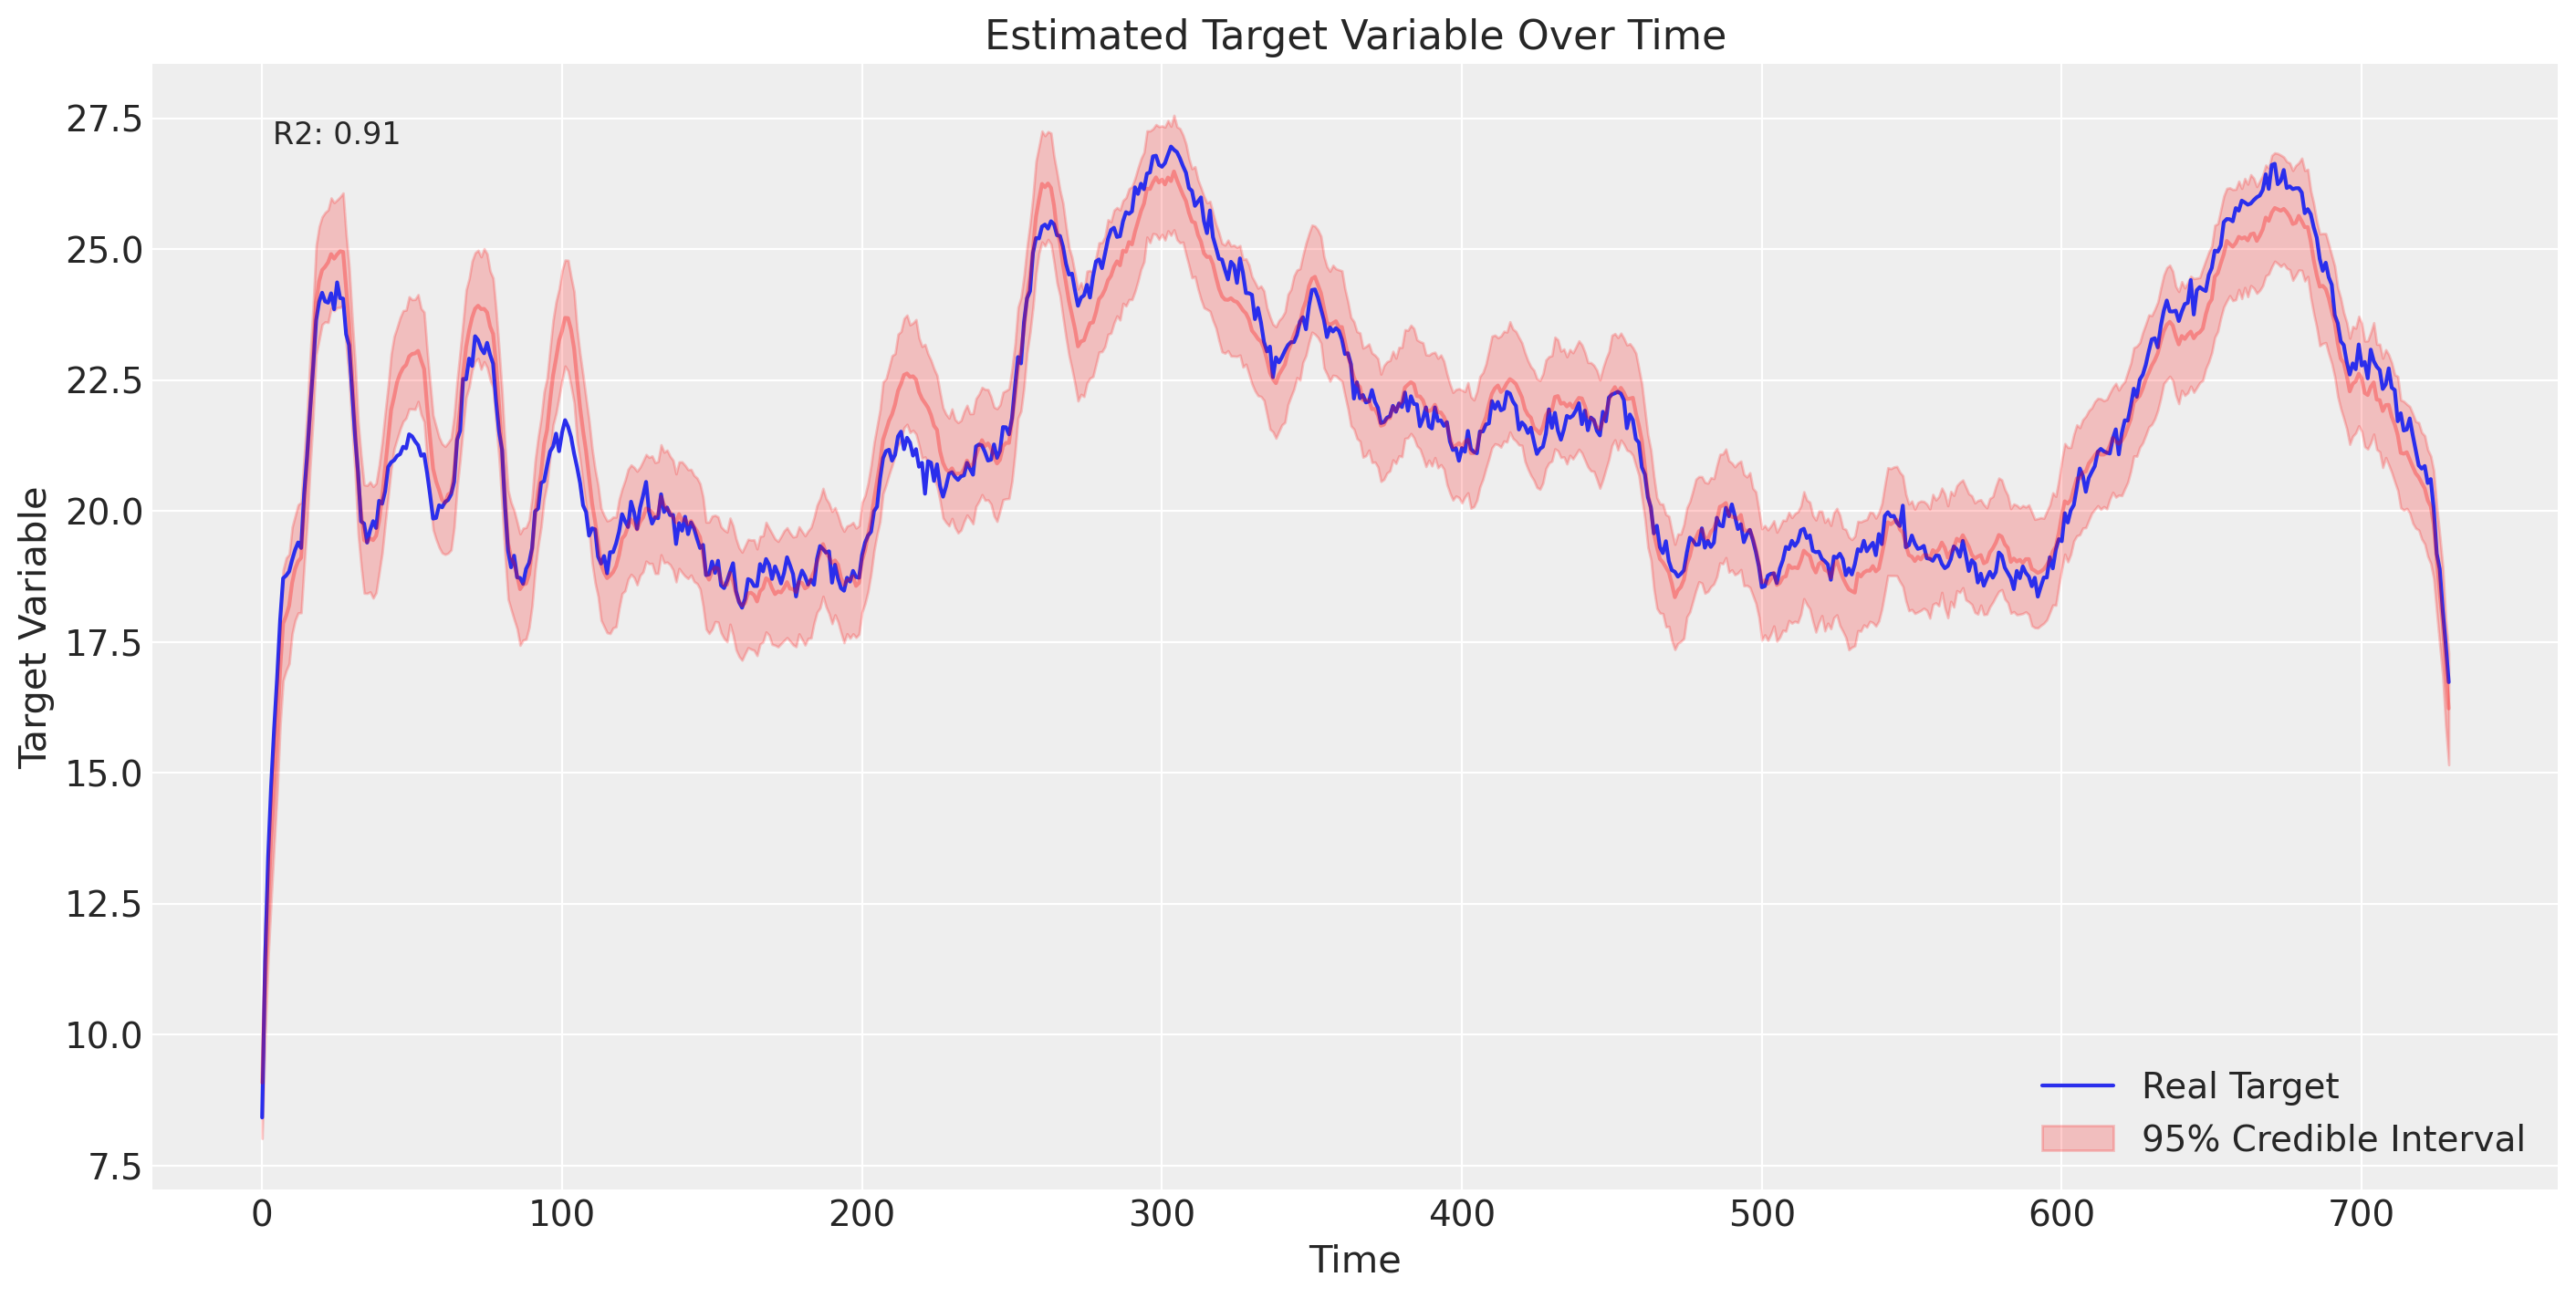

In [ ]:
# Step 1: Using arviz to calculate 95% interval from `idata.posterior_predictive`
ci = az.hdi(idata1.posterior_predictive["likelihood"], hdi_prob=0.95)

# Step 2: Visualize the Model Results
plt.figure(figsize=(14, 7))
plt.plot(target, label="Real Target")
plt.plot(idata1.posterior_predictive['likelihood'].mean(dim=["chain", "draw"]), color='red', alpha=0.3,)
plt.fill_between(
    np.arange(time_periods),
    ci.isel(hdi=0).likelihood,
    ci.isel(hdi=1).likelihood,
    color='red', alpha=0.2, label="95% Credible Interval"
)

# Step 3: Adding R2 on the left corner.
r2 = az.r2_score(target, idata1.posterior_predictive.stack(sample=("chain", "draw"))["likelihood"].values.T)[0]
plt.text(0.05, 0.95, f"R2: {r2:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title("Estimated Target Variable Over Time")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.show()

Great, our model looks amazing! At first glance, our model evaluation appears quite satisfactory. There are no signs of divergence, our sampling looks accurate, the $R^2$ value is decent, and the uncertainty in the credible intervals is manageable.

However, the pressing question remains: are we truly capturing the underlying causal signals?

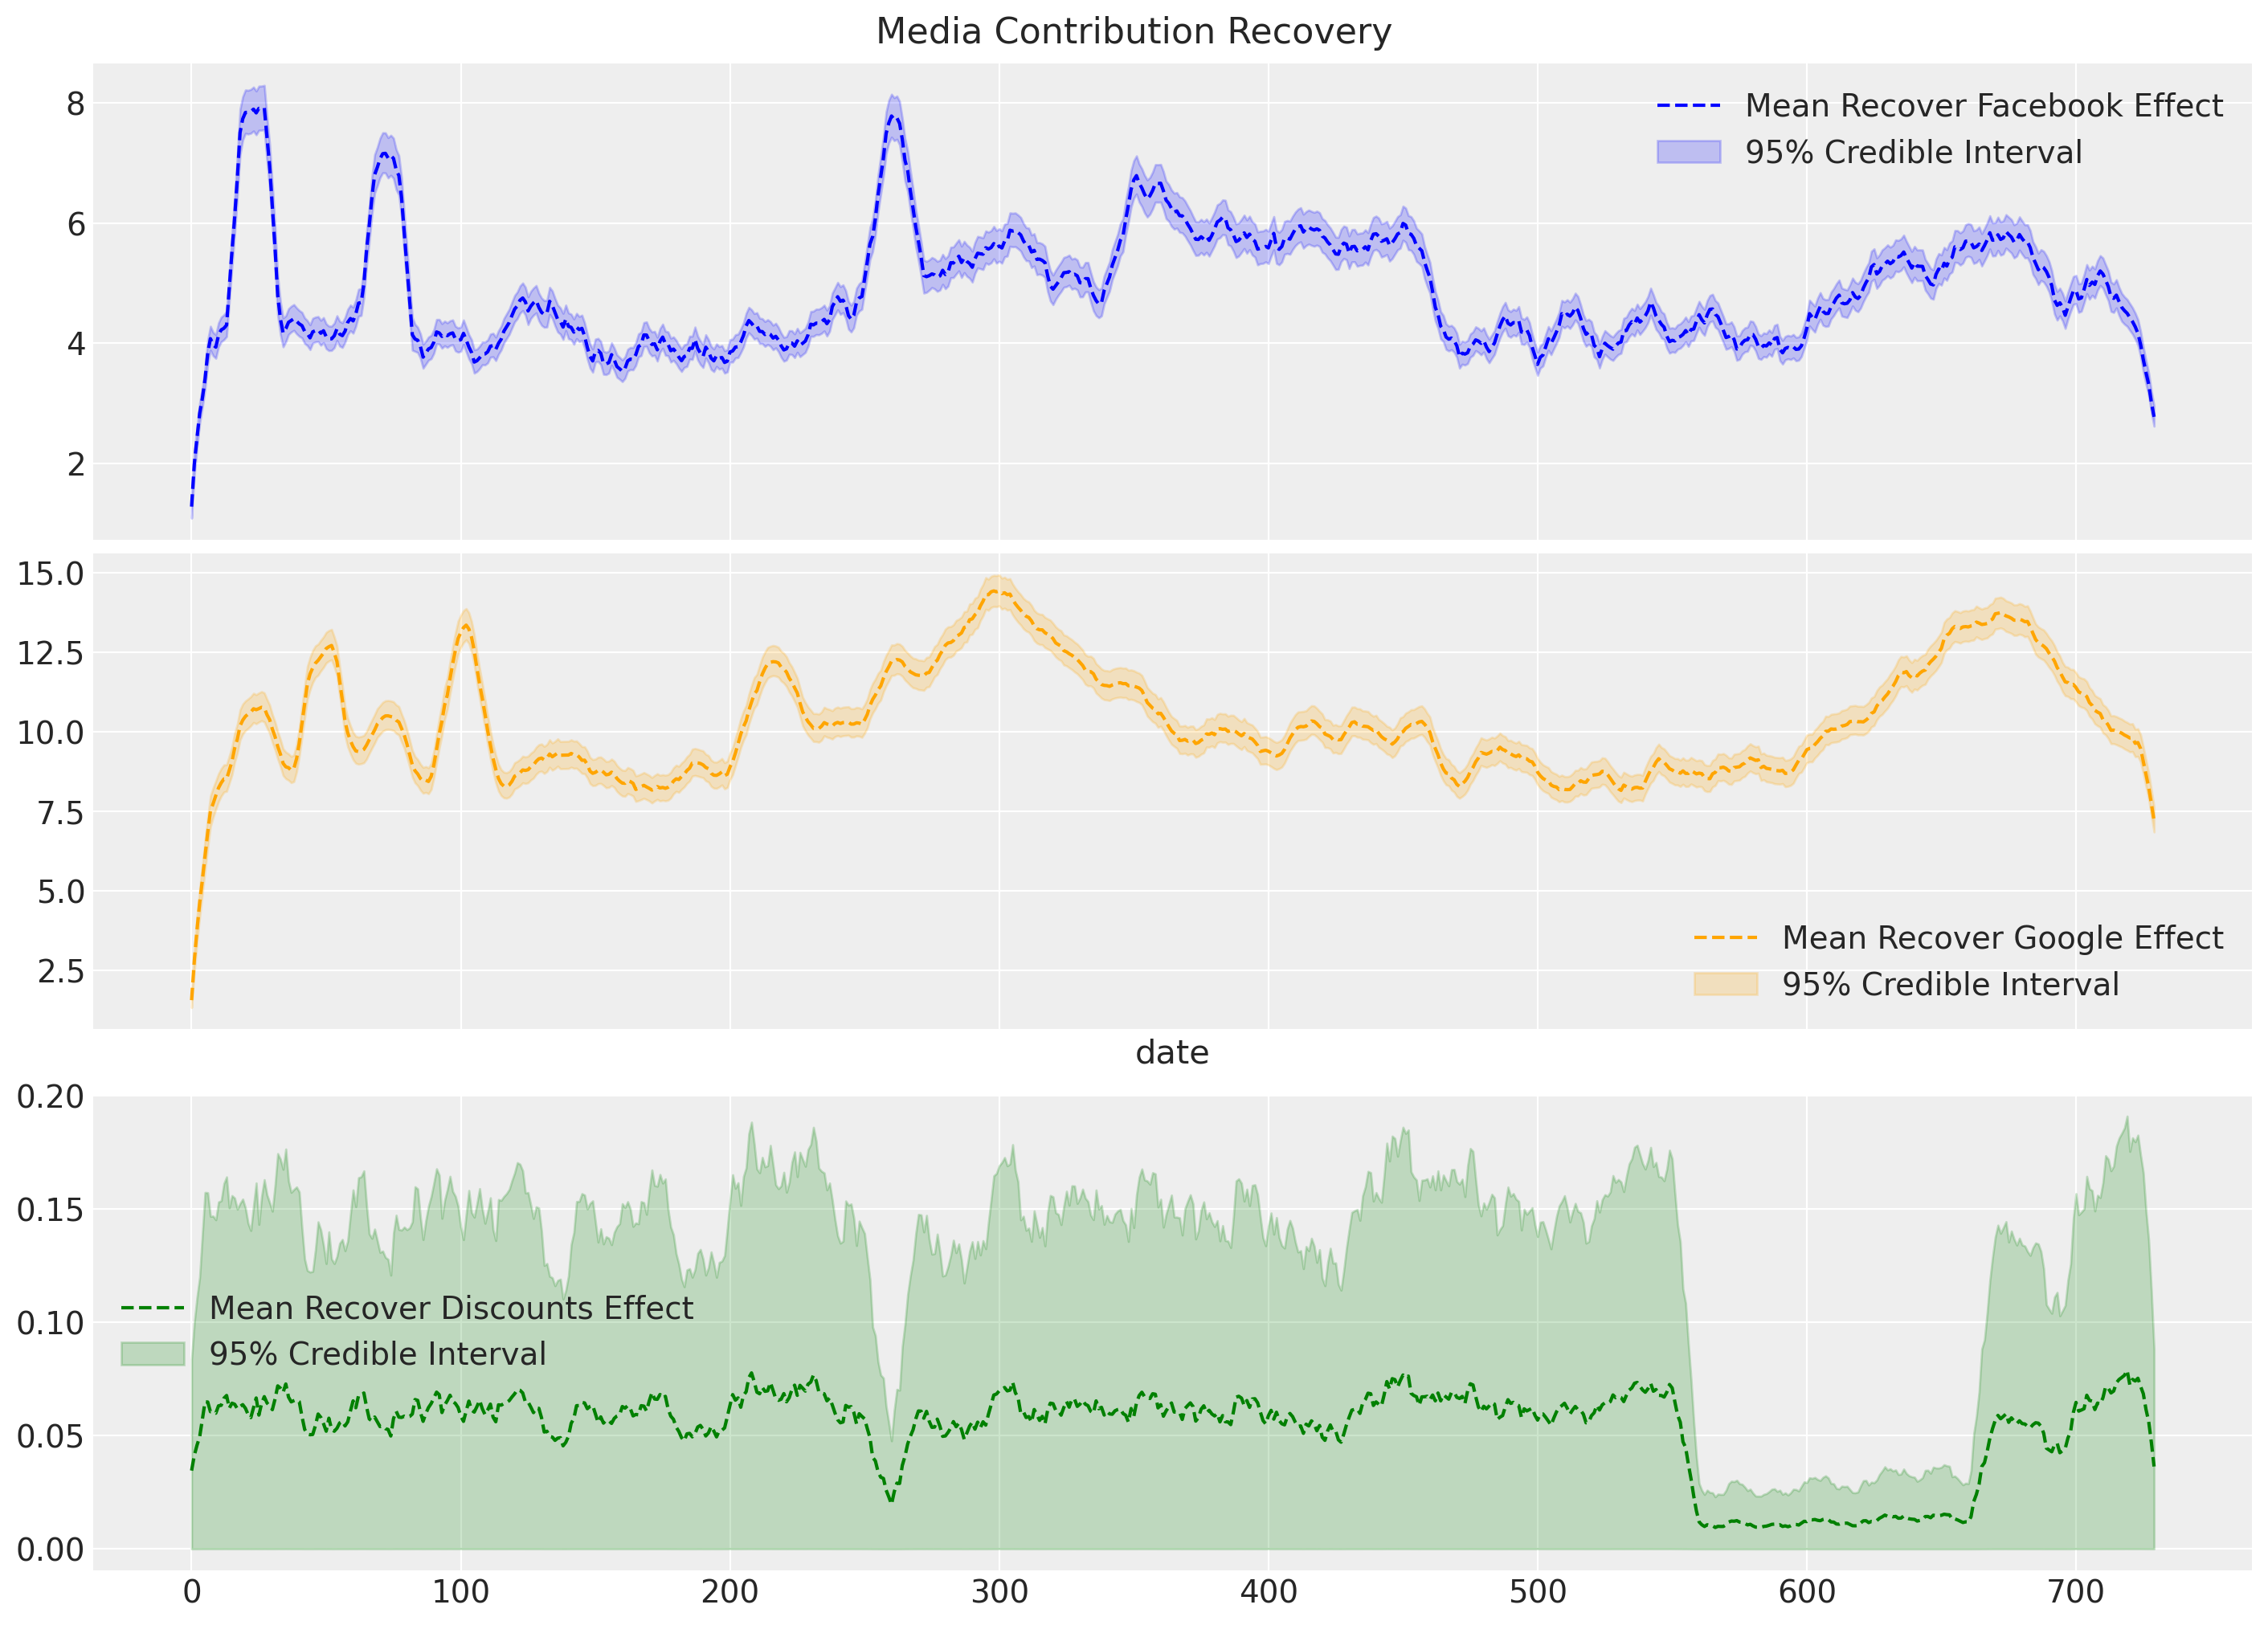

In [ ]:
initial_model_recover_effect = az.hdi(idata1.posterior["impressions_transformed"], hdi_prob=0.95)

fig, ax = plt.subplots(3,1, figsize=(14, 10), sharex=True)

# facebook
ax[0].plot(
    idata1.posterior.impressions_transformed.sel(channel="facebook").mean(dim=["chain","draw"]),
    label="Mean Recover Facebook Effect", linestyle="--", color="blue"
)
ax[0].fill_between(
    np.arange(time_periods),
    initial_model_recover_effect.impressions_transformed.isel(hdi=0).sel(channel="facebook"),
    initial_model_recover_effect.impressions_transformed.isel(hdi=1).sel(channel="facebook"),
    alpha=0.2, label="95% Credible Interval", color="blue"
)

# google
ax[1].plot(
    idata1.posterior.impressions_transformed.sel(channel="google").mean(dim=["chain","draw"]),
    label="Mean Recover Google Effect", linestyle="--", color="orange"
)
ax[1].fill_between(
    np.arange(time_periods),
    initial_model_recover_effect.impressions_transformed.isel(hdi=0).sel(channel="google"),
    initial_model_recover_effect.impressions_transformed.isel(hdi=1).sel(channel="google"),
    alpha=0.2, label="95% Credible Interval", color="orange"
)

# discounts
_model_recover_effect = az.hdi(idata1.posterior["discounts_contribution"], hdi_prob=0.95)
ax[2].plot(
    idata1.posterior.discounts_contribution.sel(discounts="discounts").mean(dim=["chain","draw"]),
    label="Mean Recover Discounts Effect", linestyle="--", color="green"
)
ax[2].fill_between(
    np.arange(time_periods),
    _model_recover_effect.discounts_contribution.isel(hdi=0).sel(discounts="discounts"),
    _model_recover_effect.discounts_contribution.isel(hdi=1).sel(discounts="discounts"),
    alpha=0.2, label="95% Credible Interval", color="green"
)

# formatting
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.grid(True)
ax[1].set(xlabel="date")
fig.suptitle("Media Contribution Recovery", fontsize=16)
plt.show()

These estimates seem pretty spot on, right? Sure, some of the newer ones have wilder values and might be a bit sketchy, but it’s not a big deal, is it?

#### **Plot twist!**
If that’s what you thought, it’s time to rethink things. Not paying attention to the causal side of your models might have led you to a wrong conclusion.

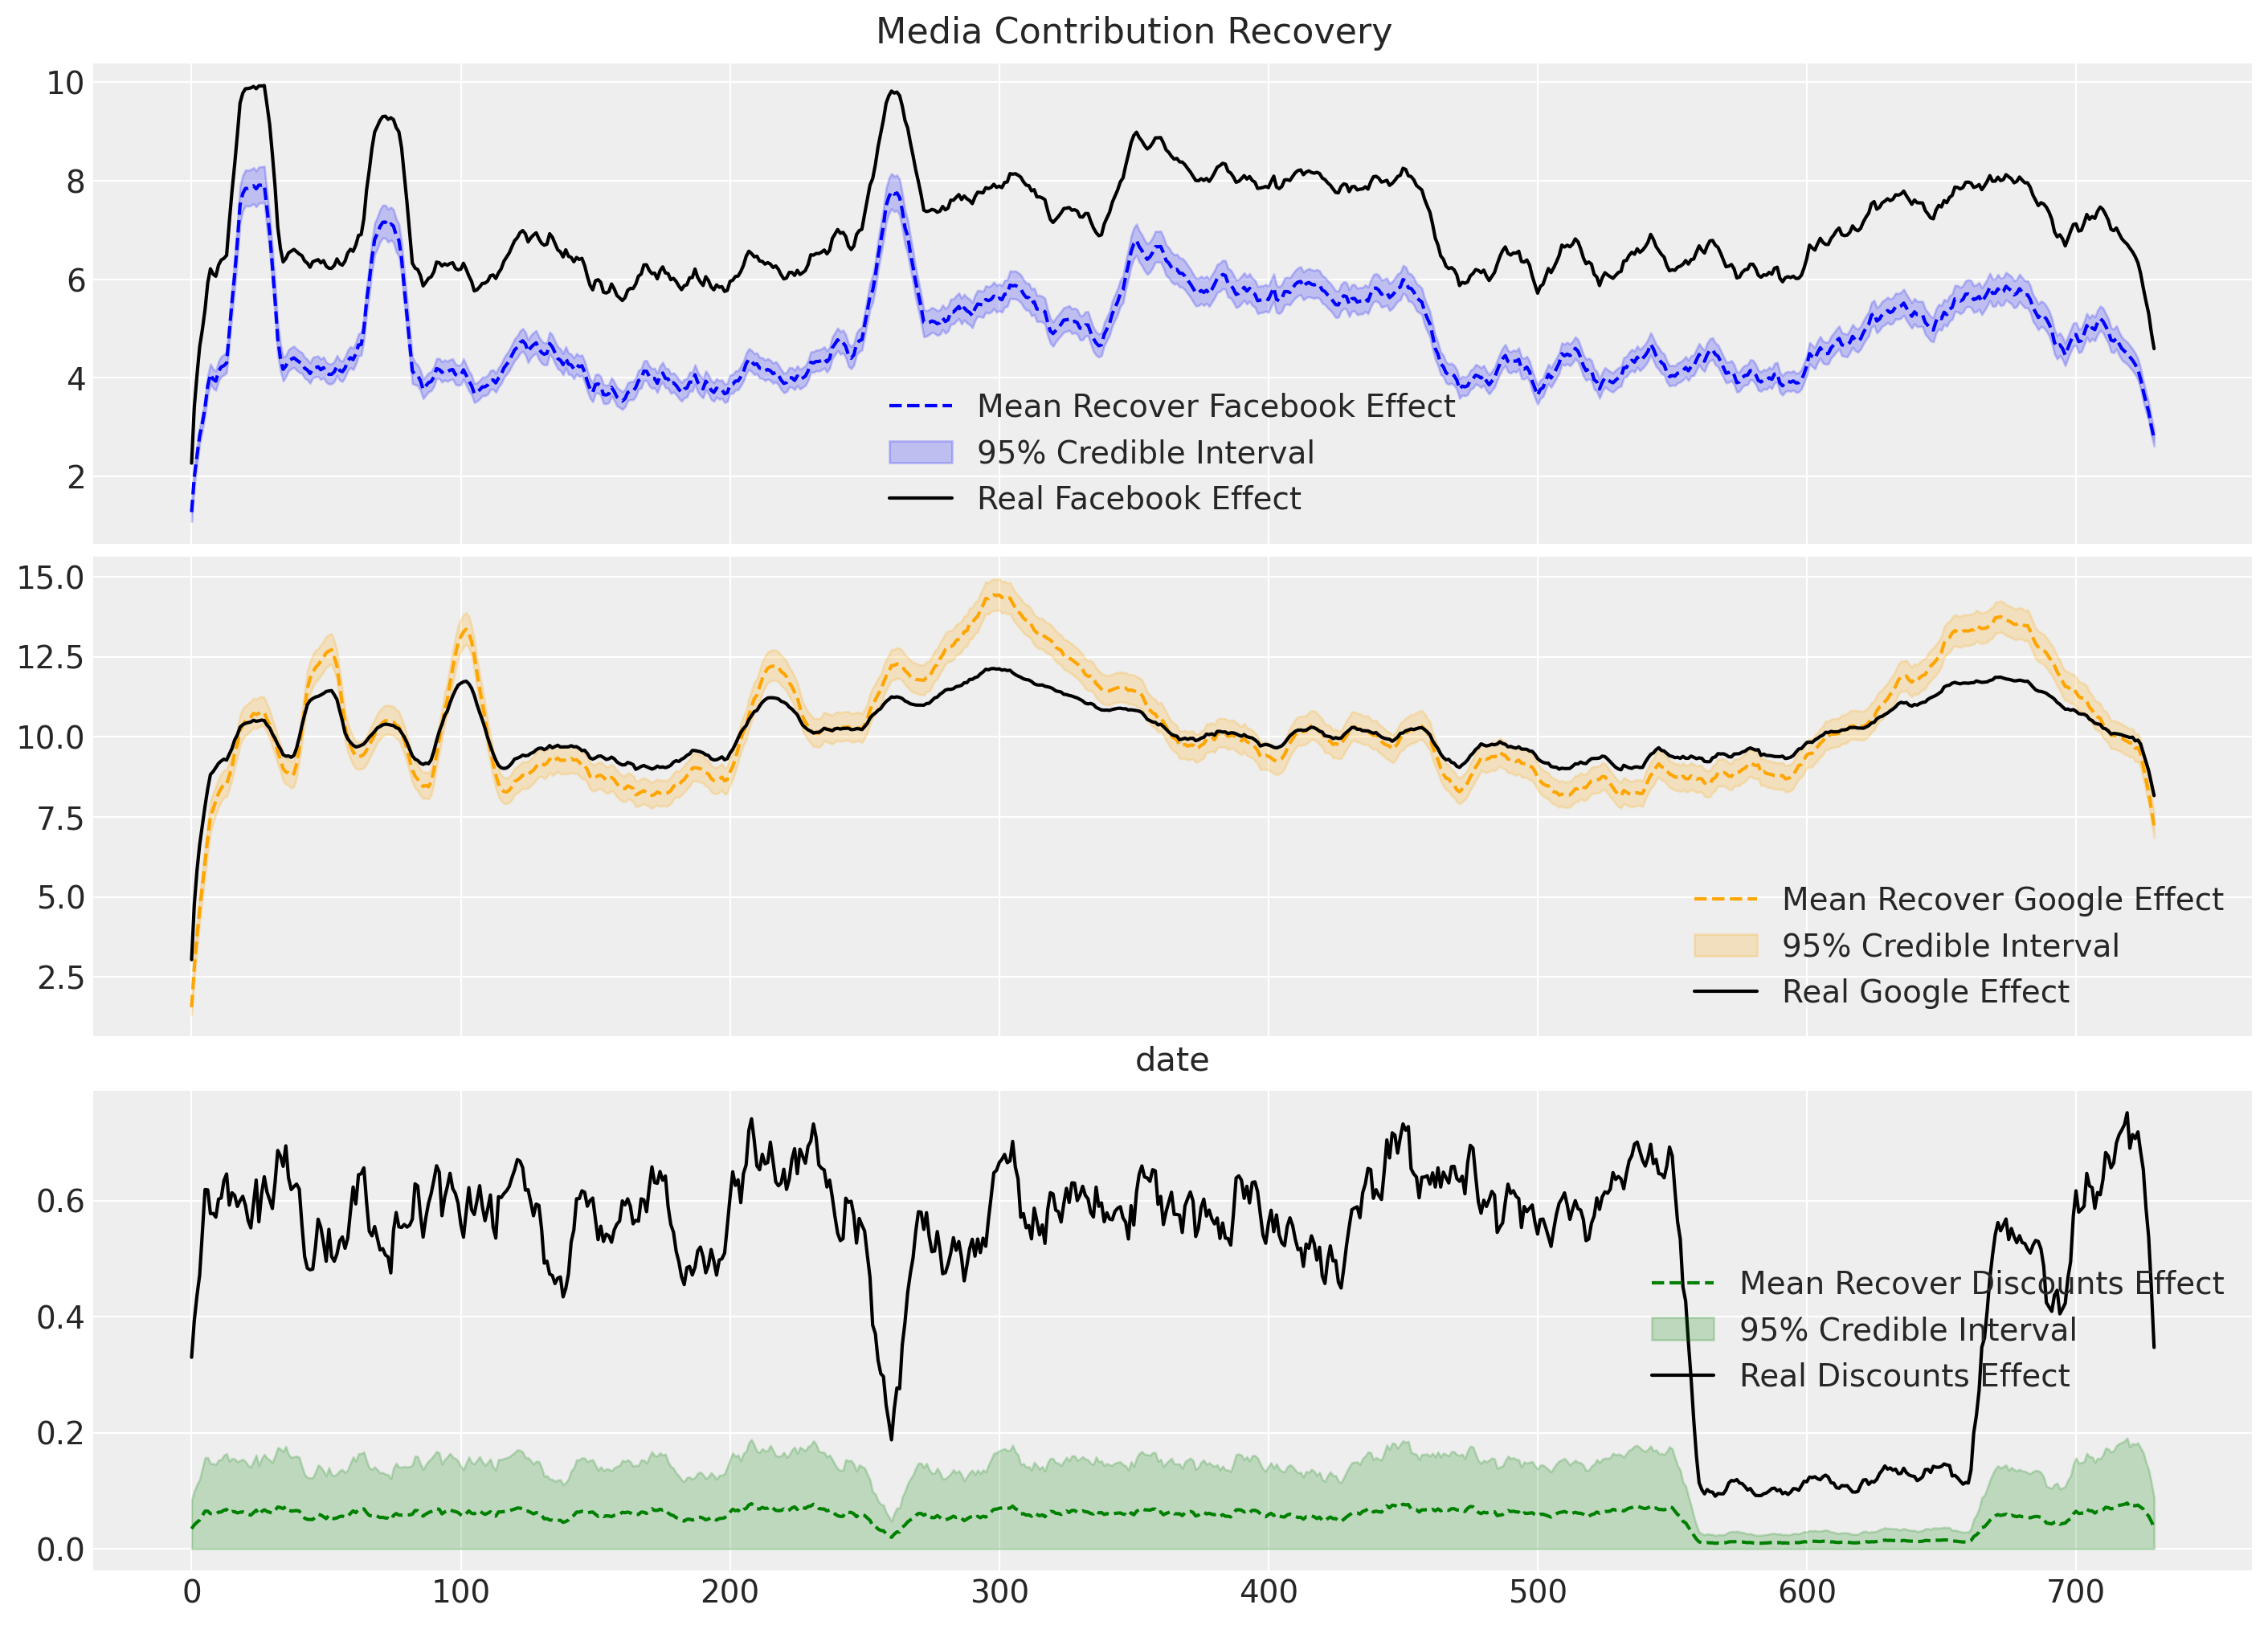

In [ ]:
initial_model_recover_effect = az.hdi(idata1.posterior["impressions_transformed"], hdi_prob=0.95)

fig, ax = plt.subplots(3,1, figsize=(14, 10), sharex=True)

# facebook
ax[0].plot(
    idata1.posterior.impressions_transformed.sel(channel="facebook").mean(dim=["chain","draw"]),
    label="Mean Recover Facebook Effect", linestyle="--", color="blue"
)
ax[0].fill_between(
    np.arange(time_periods),
    initial_model_recover_effect.impressions_transformed.isel(hdi=0).sel(channel="facebook"),
    initial_model_recover_effect.impressions_transformed.isel(hdi=1).sel(channel="facebook"),
    alpha=0.2, label="95% Credible Interval", color="blue"
)
ax[0].plot(facebook_contribution, label="Real Facebook Effect", color="black")

# google
ax[1].plot(
    idata1.posterior.impressions_transformed.sel(channel="google").mean(dim=["chain","draw"]),
    label="Mean Recover Google Effect", linestyle="--", color="orange"
)
ax[1].fill_between(
    np.arange(time_periods),
    initial_model_recover_effect.impressions_transformed.isel(hdi=0).sel(channel="google"),
    initial_model_recover_effect.impressions_transformed.isel(hdi=1).sel(channel="google"),
    alpha=0.2, label="95% Credible Interval", color="orange"
)
ax[1].plot(google_contribution, label="Real Google Effect", color="black")

# discounts
_model_recover_effect = az.hdi(idata1.posterior["discounts_contribution"], hdi_prob=0.95)
ax[2].plot(
    idata1.posterior.discounts_contribution.sel(discounts="discounts").mean(dim=["chain","draw"]),
    label="Mean Recover Discounts Effect", linestyle="--", color="green"
)
ax[2].fill_between(
    np.arange(time_periods),
    _model_recover_effect.discounts_contribution.isel(hdi=0).sel(discounts="discounts"),
    _model_recover_effect.discounts_contribution.isel(hdi=1).sel(discounts="discounts"),
    alpha=0.2, label="95% Credible Interval", color="green"
)
ax[2].plot(daily_discounts_contribution, label="Real Discounts Effect", color="black")

# formatting
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.grid(True)
ax[1].set(xlabel="date")
fig.suptitle("Media Contribution Recovery", fontsize=16)
plt.show()

Looking at our model a bit closer, it’s clear the estimates are totally off. If we had actually followed its suggestions, we might have ended up spending double on Facebook and slashed our discounts by ten times, which could have really hurt our revenue.

But why did this happen?

### The graphical model behind
Previously we had defined our model in the following mathematical equation.

$$
\begin{aligned}
\mu & = \beta_0 \cdot \text{baseline} + \beta_1 \cdot \text{discounts} + m(\text{facebook}, \theta_{\text{facebook}}) + m(\text{google}, \theta_{\text{google}})
\end{aligned}
$$

During the development of our model, we established a specific structure and flow for our data. We concluded that the impacts of our channels operate independently of each other. Moreover, we determined that if any component of our ecosystem is missing, its influence will be accounted for by the baseline term due to this equation. As you can see, even by adopting this basic model, we are making significant assumptions.

On one hand, you are assuming that the impact is not linear by applying these transformations, and you are suggesting that the impact is positive and that there may be a maximum delay of a certain number of days.

You've even defined the direction of your relationships. By defining these relationships and assuming no direct causal connections between our variables, we can conclude that, if the nature of their relationship is accurately represented by the provided equation, then by controlling the relevant channels, we could uncover their true effects.

This leads us to the assumption of the following causal directed acyclic graph (DAG).

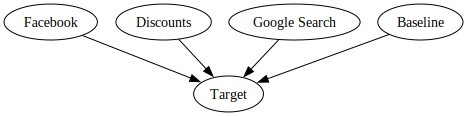

In [ ]:
model1_dot = Digraph()

# Add nodes
model1_dot.node('F', 'Facebook')
model1_dot.node('D', 'Discounts')
model1_dot.node('G', 'Google Search')
model1_dot.node('T', 'Target')
model1_dot.node('B', 'Baseline')

# Add edges to represent the relationships
model1_dot.edge('F', 'T')  # Facebook contributes Target
model1_dot.edge('G', 'T')  # Google Search contributes to Target
model1_dot.edge('D', 'T')  # Discounts contributes to Target
model1_dot.edge('B', 'T')

# Render the graph to SVG and display it inline
svg_str = model1_dot.pipe(format='svg')
display(SVG(svg_str))

$$
\begin{aligned}
\mu & = \beta_0 \cdot \text{baseline} + \beta_1 \cdot \text{discounts} +
   m(\text{facebook}, \theta_{\text{facebook}}) +
   m(\text{google}, \theta_{\text{google}})
\end{aligned}
$$


Congratulations, if you hadn't noticed, you have created a generative model or SCM (Structural Causal Model), given a SCE (Structural Causal Equation).

In [ ]:
# Probably add how to find your model is wrong (experiments) / lift tests
# but even then you are just trying to calibrate and it might not work if you still have the wrong causal DAG

## Model 2: The Causal Bayesian Model

As we've seen, simply adding variables to our analysis without considering their causal relationships can prevent us from uncovering the true causal effect. **Even more importantly, in the process of modeling we may be making decisions about the causal structure of our model without even realizing it.** So, what’s the alternative approach?

What if we shifted our perspective and actively thought about the causal connections within our data? Based on our understanding of the business, we could start with the directed acyclic graph (DAG) we've initially proposed.

Let me introduce you to a new library... `DoWhy`. We can use it to represent our DAGs (Theories about how we believe our information is generated). **DoWhy** is a Python library designed to streamline causal inference analysis, offering a comprehensive framework for defining, estimating, and validating causal effects. This tool allows researchers and data scientists to apply causal reasoning to their datasets more effectively, leveraging structural causal models (SCMs) and DAGs.

Once we set up the model with our diagram in DoWhy, we can begin to ask insightful causal queries!

In [ ]:
causal_graph = """
digraph {
    facebook
    google
    holiday
    discounts
    net_sales_amount

    facebook -> net_sales_amount
    google -> net_sales_amount
    discounts -> net_sales_amount

    facebook -> google

    holiday -> facebook
    holiday -> google
}
"""

# Build the causal model
model = CausalModel(
    data=df,  # We don't need data for just the DAG
    treatment=["google", "facebook", "discounts"],
    outcome="net_sales_amount",
    graph=causal_graph
)

We can utilize `get_backdoor_paths` to pinpoint potential backdoor paths in the causal graph. These paths signify indirect routes that may create false associations between the treatment and outcome variables.

Such paths can introduce dependencies that can skew causal estimates if not adequately addressed. To accurately gauge the causal effect, it’s essential to block these paths, typically by adjusting for the confounders along the way.

We can formulate a causal query asking DoWhy to identify all backdoor paths from the node "google" (the treatment or exposure variable) to "net_sales_amount" (the outcome variable). This function uncovers paths that might lead to confounding if not managed properly, allowing us to adjust for variables along these routes and clarify the causal effect of "google" on "net_sales_amount."

In [ ]:
model._graph.get_backdoor_paths(nodes1=["google"], nodes2=["net_sales_amount"])

[['google', 'facebook', 'net_sales_amount'],
 ['google', 'holiday', 'facebook', 'net_sales_amount']]

To uncover the true causal effect of Google, it's essential to control for Facebook, as shown in the first graph that illustrates the relationships among holidays, media channels, and the target variable.

Additionally, we could control for both holidays and Facebook to accurately determine Google’s real impact.

This is particularly insightful because if our sole interest was measuring Google, we wouldn’t need to account for holidays to gauge its effect properly. Aleksander Molak delves into this topic in their book, ["Causal Inference and Discovery in Python"](https://www.amazon.com/Causal-Inference-Discovery-Python-learning/dp/1804612987/ref=sr_1_1?crid=MPRZHLBAU3O5&dib=eyJ2IjoiMSJ9.K83e_nuq1Q9BLCy42T6IgcIBpjGAFoAoViGABamdiF_GjHj071QN20LucGBJIEps.e7gyLxqde72Szgu8tRr8oWmXeKeyKX3fHfmkfTci0_A&dib_tag=se&keywords=aleksander+molak&qid=1729955014&sprefix=aleksander+molak%2Caps%2C169&sr=8-1).

In [ ]:
model._graph.get_backdoor_paths(nodes1=["facebook"], nodes2=["net_sales_amount"])

[['facebook', 'holiday', 'google', 'net_sales_amount']]

Now, if we want to make a model that can find the causal impact of `Facebook`, we need to control for `Holiday` and `Google`.

This means, in order to understand not only `Google` but as well `Facebook`, we'll need to control by `Holiday`




In [ ]:
model._graph.get_backdoor_paths(nodes1=["discounts"], nodes2=["net_sales_amount"])

To understand the causal impact of discounts, there’s no need to control for additional factors. Now, let's say we’ve run experiments in the past that revealed the causal effect indicated by our model isn’t accurate when it comes to discounts. So, what might be missing?

It’s possible that we don’t fully grasp the relationship between the strength of discounts and our target variable. This conclusion is based on our prior experiences.

Furthermore, from the queries we conducted using **DoWhy**, we’ve identified the need to incorporate the **holiday** variable. So, let’s consider estimating that variable as well.

In [ ]:
df["holiday"] = holiday

In [ ]:
def build_bayesian_model():
  coords = {
      "time": df.time.unique(),
      "channel": ["facebook", "google"],
      "discounts": ["discounts"],
      "holiday": ["holiday"]
  }

  # Step 1: Define the PyMC Model with Transformed Variables
  with pm.Model(coords=coords) as model:
      # Load Data
      _raw_impressions = pm.Data(
          "raw_impressions",
          value=df[["facebook", "google"]].values,
          dims=("time", "channel")
      )

      _raw_discounts = pm.Data(
          "raw_discounts",
          value=df[["discounts"]].values,
          dims=("time", "discounts")
      )

      _raw_holiday = pm.Data(
          "raw_holiday",
          value=df[["holiday"]].values,
          dims=("time", "holiday")
      )

      _target = pm.Data(
          "target",
          value=df["net_sales_amount"].values,
          dims="time"
      )

      # Priors for unknown model parameters
      _base = pm.Gamma("base", mu=3, sigma=.5)

      # Prior for alpha saturation
      _alpha_saturation = pm.Gamma("alpha_saturation", mu=20, sigma=10, dims="channel")

      # Prior for alpha adstock
      _alpha_adstock = pm.Beta("alpha_adstock", alpha=20, beta=30, dims="channel")

      # Prior for lam
      _lam = pm.Gamma("lam", mu=20, sigma=10)

      # Transforming the Facebook and Google variables
      _impressions_contribution_raw = pm.Deterministic(
          'impressions_contribution_raw',
          michaelis_menten(
              geometric_adstock(_raw_impressions, alpha=_alpha_adstock, l_max=28),
              alpha=_alpha_saturation,
              lam=_lam
          ),
          dims=("time","channel")
      )

      _discounts_beta = pm.Gamma("discounts_beta", mu=1, sigma=1)
      _discounts_contribution = pm.Deterministic(
          "discounts_contribution",
          _discounts_beta * _raw_discounts,
          dims=("time", "discounts")
      )

      _holiday_beta = pm.Gamma("holiday_beta", mu=3, sigma=1.5, dims="holiday")
      _holiday_contribution = pm.Deterministic(
          "holiday_contribution",
          _raw_holiday * _holiday_beta,
          dims=("time", "holiday")
      )

      _beta_moderator = pm.Beta(
          "beta_moderator",
          alpha=2,
          beta=6,
          dims="channel"
      )

      _media_contribution_moderation = pm.Deterministic(
          'media_contribution_moderation',
          _raw_impressions * _raw_discounts.sum(axis=-1)[:,None] * _beta_moderator[None,:],
          dims=("time", "channel")
      )

      _impressions_contribution = pm.Deterministic(
          '_impressions_contribution',
          _media_contribution_moderation + _impressions_contribution_raw,
          dims=("time","channel")
      )

      # Expected value of target variable
      mu = (
          _base +
          _holiday_contribution.sum(axis=-1) +
          _impressions_contribution.sum(axis=-1) +
          _discounts_contribution.sum(axis=-1)
      )

      sigma = pm.Gamma("sigma_likelihood", mu=3, sigma=1)

      # Likelihood (sampling distribution) of observations
      likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=_target, dims="time")
      return model

model2 = build_bayesian_model()

In [ ]:
with model2:
    idata = pm.sample_prior_predictive(random_seed=rng)
    idata.extend(pm.sample(random_seed=rng, **sample_kwargs))
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

Sampling: [alpha_adstock, alpha_saturation, base, beta_moderator, discounts_beta, holiday_beta, lam, likelihood, sigma_likelihood]


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

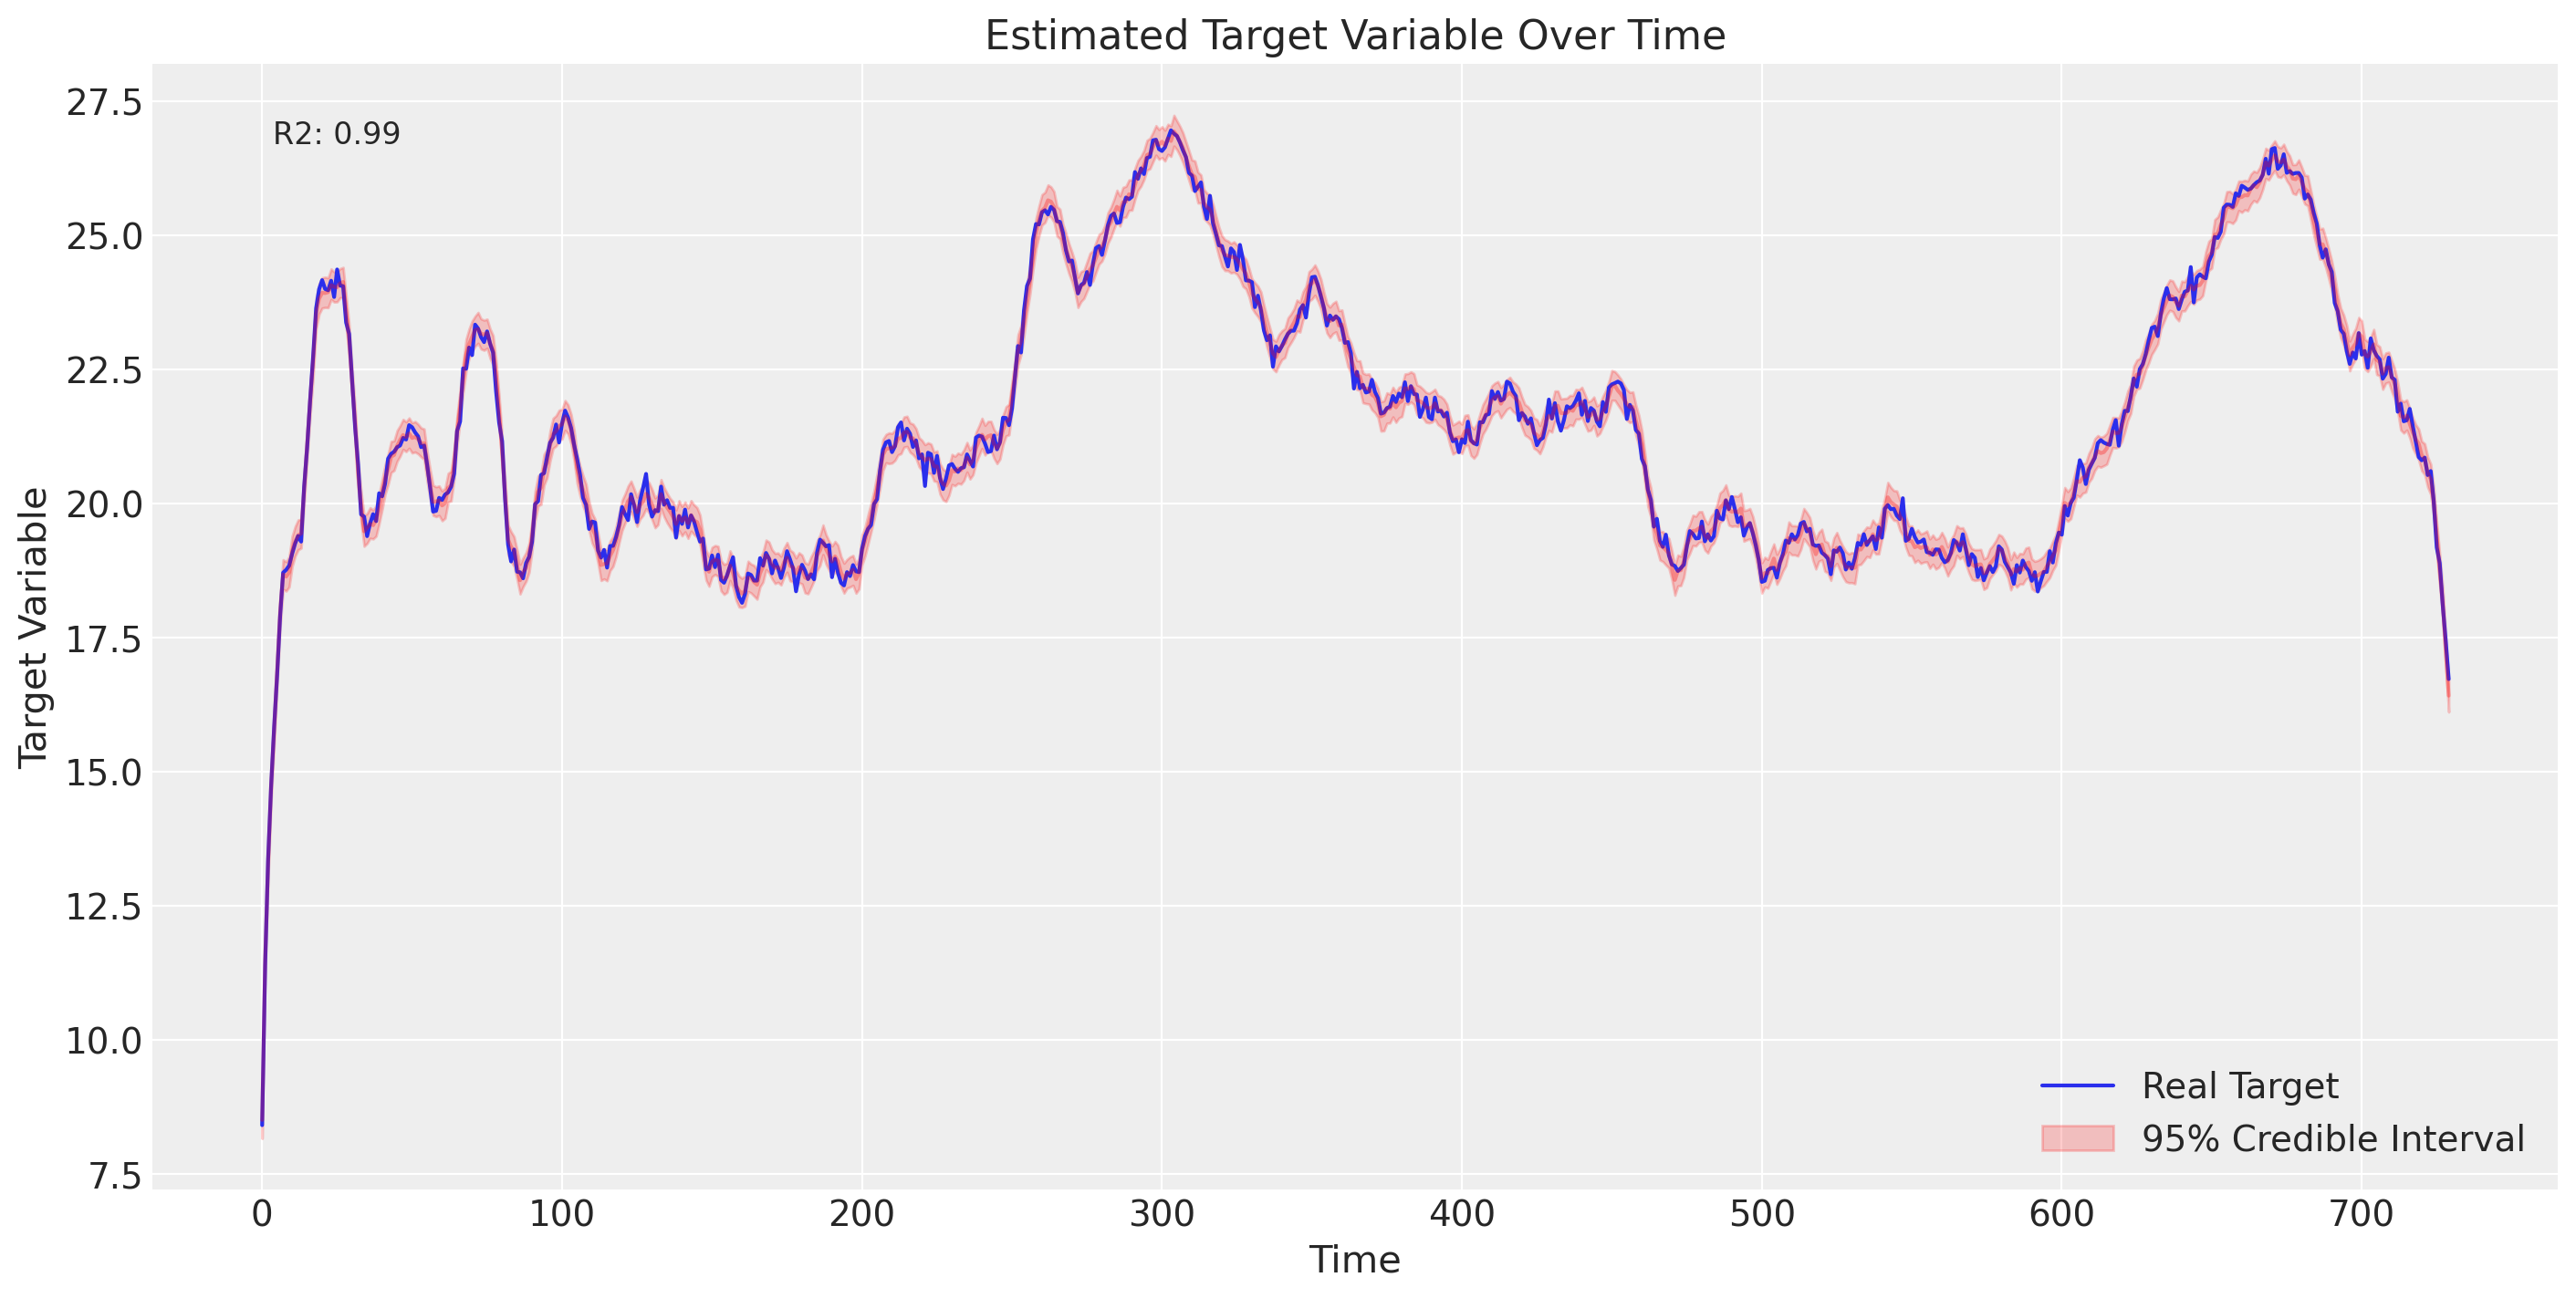

In [ ]:
# Step 1: Using arviz to calculate 95% interval from `idata.posterior_predictive`
ci = az.hdi(idata.posterior_predictive["likelihood"], hdi_prob=0.95)

# Step 2: Visualize the Model Results
plt.figure(figsize=(14, 7))
plt.plot(target, label="Real Target")
plt.plot(idata.posterior_predictive['likelihood'].mean(dim=["chain", "draw"]), color='red', alpha=0.3,)
plt.fill_between(np.arange(time_periods), ci.isel(hdi=0).likelihood, ci.isel(hdi=1).likelihood, color='red', alpha=0.2, label="95% Credible Interval")

# Step 3: Adding R2 on the left corner.
r2 = az.r2_score(target, idata.posterior_predictive.stack(sample=("chain", "draw"))["likelihood"].values.T)[0]
plt.text(0.05, 0.95, f"R2: {r2:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title("Estimated Target Variable Over Time")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.show()

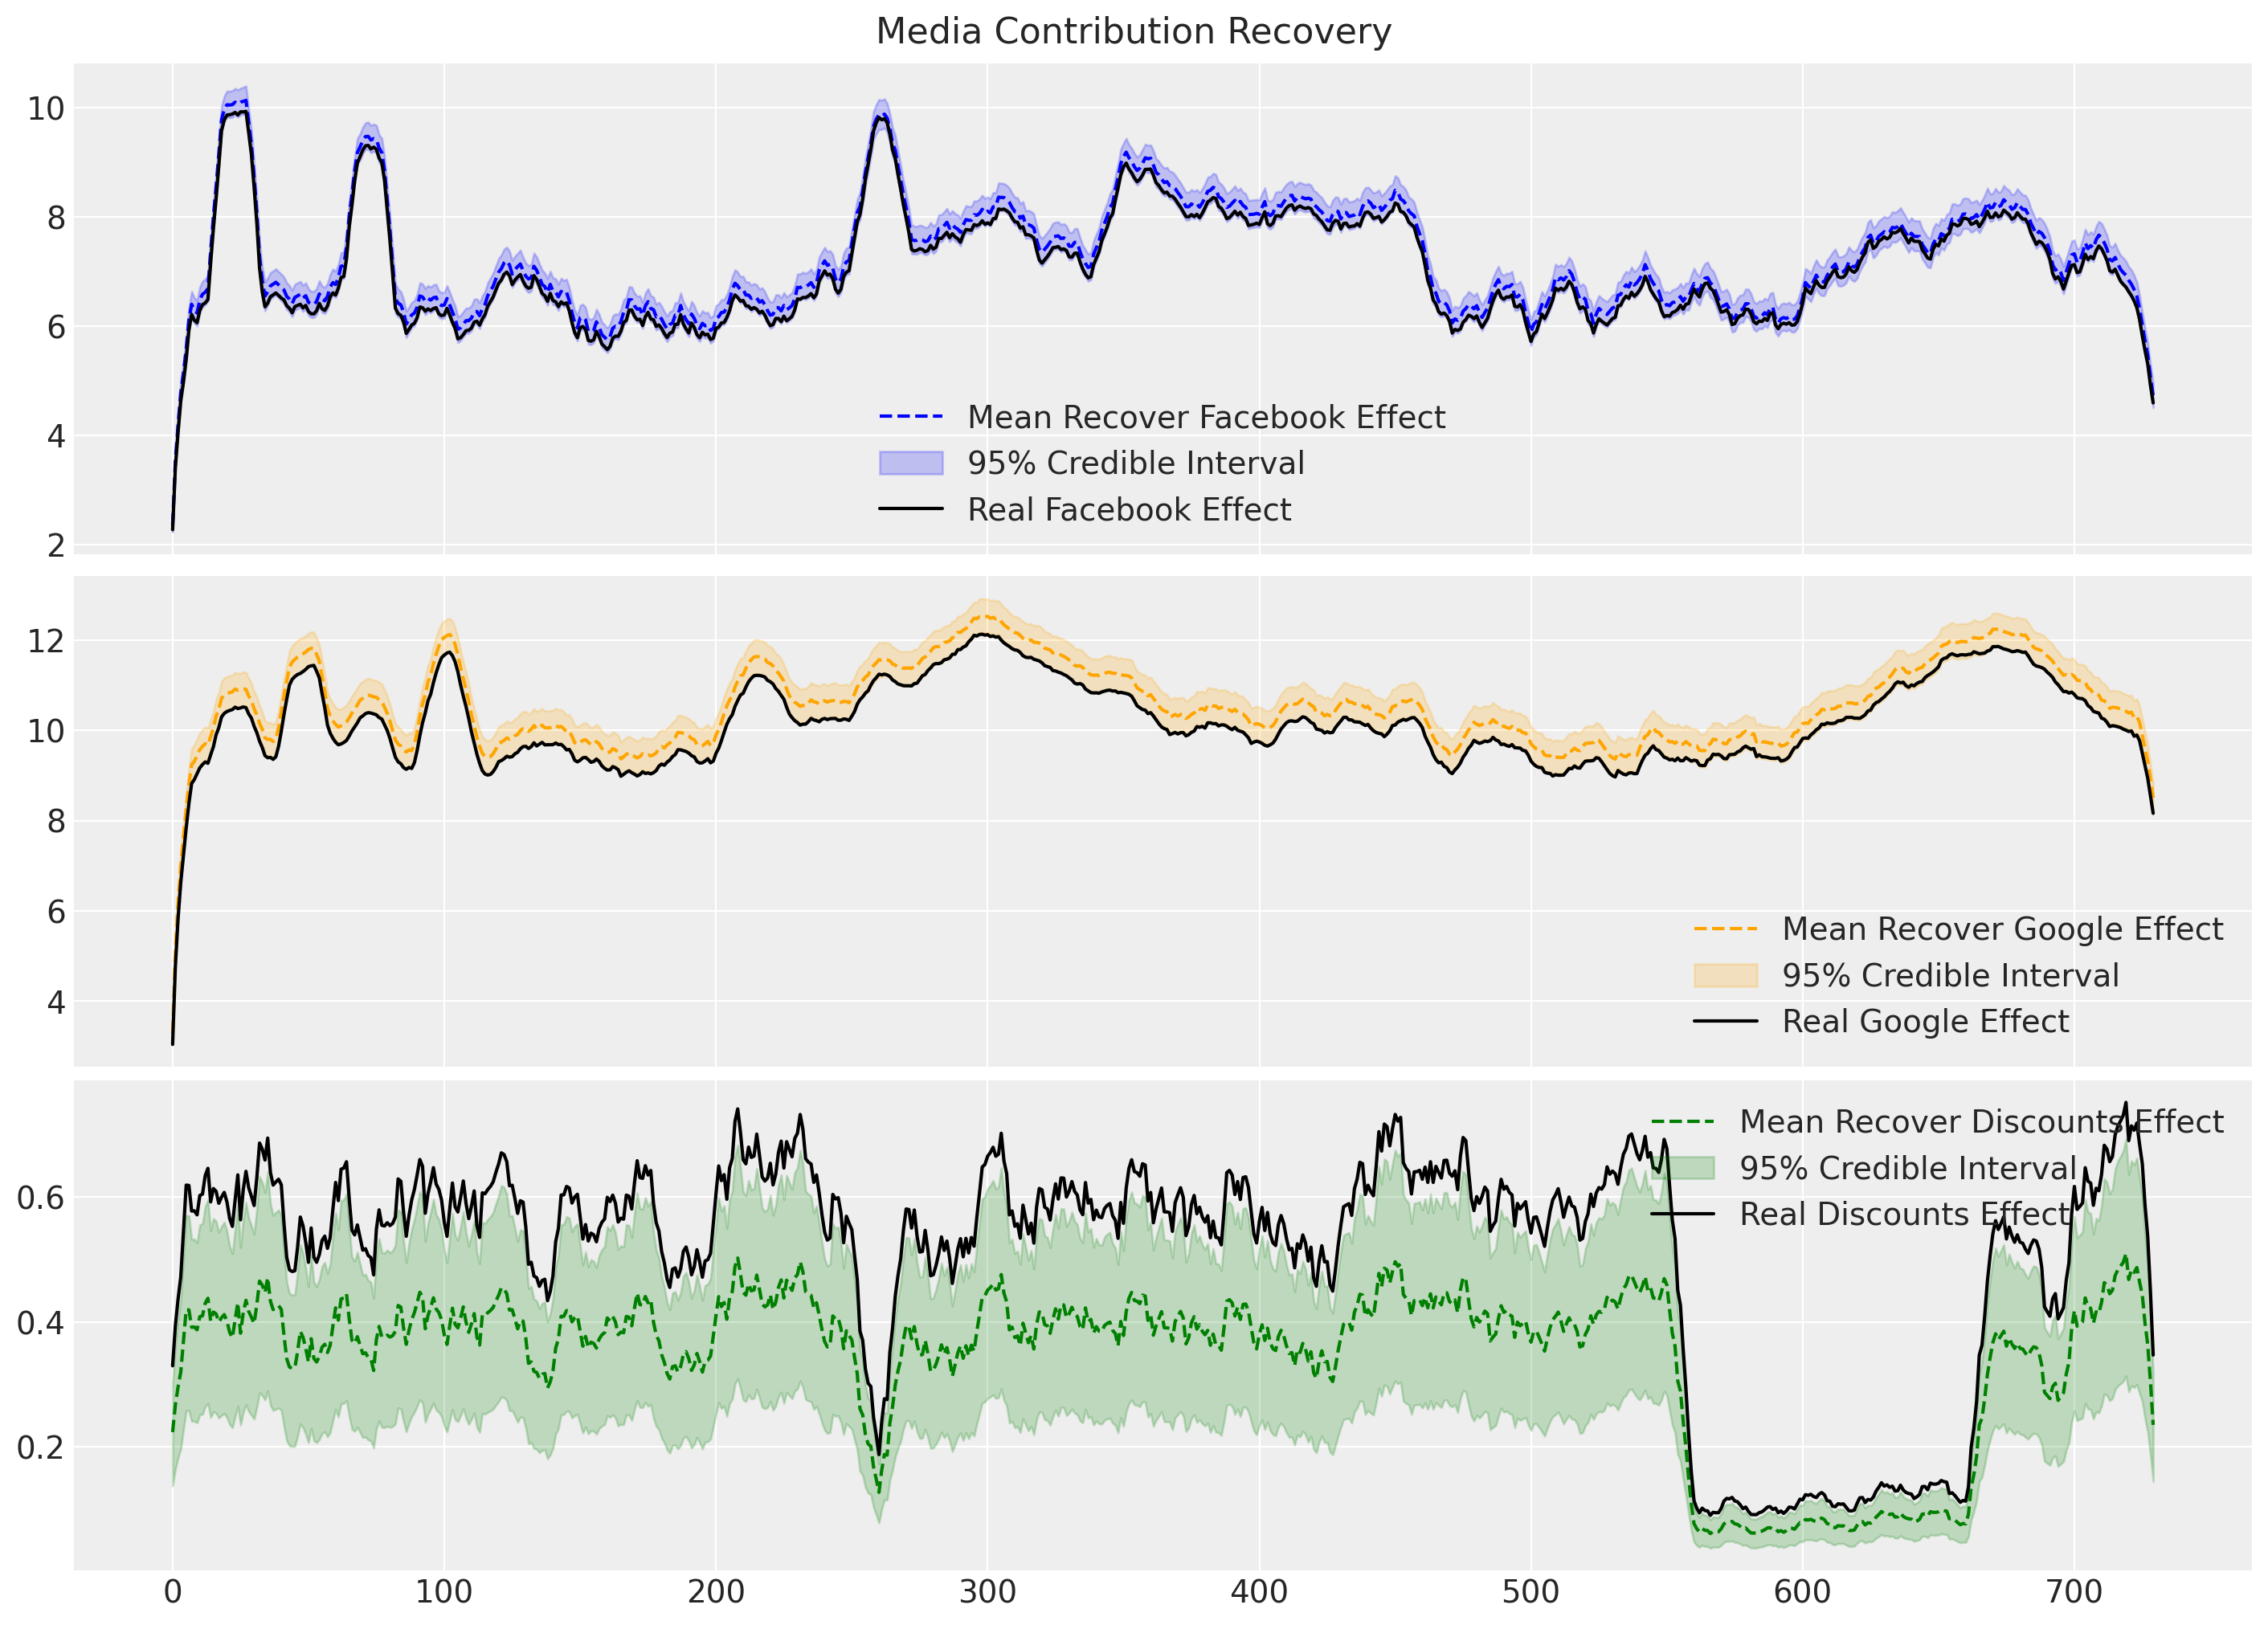

In [ ]:
initial_model_recover_effect = az.hdi(idata.posterior["_impressions_contribution"], hdi_prob=0.95)

fig, ax = plt.subplots(3,1, figsize=(14, 10), sharex=True)
ax[0].plot(
    idata.posterior._impressions_contribution.sel(channel="facebook").mean(dim=["chain","draw"]),
    label="Mean Recover Facebook Effect", linestyle="--", color="blue"
)
ax[0].fill_between(
    np.arange(time_periods),
    initial_model_recover_effect._impressions_contribution.isel(hdi=0).sel(channel="facebook"),
    initial_model_recover_effect._impressions_contribution.isel(hdi=1).sel(channel="facebook"),
    alpha=0.2, label="95% Credible Interval", color="blue"
)
ax[0].plot(facebook_contribution, label="Real Facebook Effect",color="black")

ax[1].plot(
    idata.posterior._impressions_contribution.sel(channel="google").mean(dim=["chain","draw"]),
    label="Mean Recover Google Effect", linestyle="--", color="orange"
)
ax[1].fill_between(
    np.arange(time_periods),
    initial_model_recover_effect._impressions_contribution.isel(hdi=0).sel(channel="google"),
    initial_model_recover_effect._impressions_contribution.isel(hdi=1).sel(channel="google"),
    alpha=0.2, label="95% Credible Interval", color="orange"
)
ax[1].plot(google_contribution, label="Real Google Effect",color="black")

_model_recover_effect = az.hdi(idata.posterior["discounts_contribution"], hdi_prob=0.95)

ax[2].plot(
    idata.posterior.discounts_contribution.sel(discounts="discounts").mean(dim=["chain","draw"]),
    label="Mean Recover Discounts Effect", linestyle="--", color="green"
)
ax[2].fill_between(
    np.arange(time_periods),
    _model_recover_effect.discounts_contribution.isel(hdi=0).sel(discounts="discounts"),
    _model_recover_effect.discounts_contribution.isel(hdi=1).sel(discounts="discounts"),
    alpha=0.2, label="95% Credible Interval", color="green"
)
ax[2].plot(daily_discounts_contribution, label="Real Discounts Effect",color="black")

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.grid(True)
fig.suptitle("Media Contribution Recovery", fontsize=16)
plt.show()

In [ ]:
az.summary(idata, var_names=["base", "holiday_beta", "discounts_beta", "beta_moderator", "alpha_saturation", "alpha_adstock", "lam"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
base                         2.652  0.234   2.234    3.105      0.007   
holiday_beta[holiday]        3.008  0.028   2.953    3.059      0.001   
discounts_beta               1.017  0.198   0.624    1.354      0.007   
beta_moderator[facebook]     0.064  0.037   0.007    0.134      0.001   
beta_moderator[google]       0.028  0.016   0.002    0.058      0.000   
alpha_saturation[facebook]  23.472  0.586  22.417   24.590      0.024   
alpha_saturation[google]    19.721  0.285  19.178   20.242      0.008   
alpha_adstock[facebook]      0.401  0.017   0.369    0.435      0.000   
alpha_adstock[google]        0.595  0.010   0.577    0.615      0.000   
lam                         17.958  0.774  16.536   19.442      0.027   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
base                          0.005    1083.0    1146.0   1.00  
holiday_beta[holiday]         0.001    1296.0     987.0   1.00  
discounts_beta                0.005     850.0     785.0   1.01  
beta_moderator[facebook]      0.001     779.0     847.0   1.00  
beta_moderator[google]        0.000    1313.0    1277.0   1.01  
alpha_saturation[facebook]    0.017     635.0     756.0   1.00  
alpha_saturation[google]      0.006    1214.0    1253.0   1.00  
alpha_adstock[facebook]       0.000    1410.0    1142.0   1.01  
alpha_adstock[google]         0.000    1128.0    1452.0   1.00  
lam                           0.019     810.0     903.0   1.00

As you can see, most of the parameters were successfully recovered and the recovered contribution to the real one is quite close.

## Conclusion

What have we learned here? We have possibly learnt that we’ve been doing science wrong all this time. You really cannot just throw all your variables into a regression and hope for the best. You need to think about the causal relationships between your variables and then include the good controls. If you include bad controls, then you will get the wrong answer and fool yourself and publish stuff that is wrong.

However, there is a message of hope. We learn how to use **DoWhy** to distinguish the good from the bad controls. Meaning, if you learn about causal reasoning and discovery, you can do better science. You can get the right answer and publish stuff that is less wrong.